In [1]:
from prophet import Prophet
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
import plotly.offline as py
import matplotlib as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import holidays
from sklearn.metrics import r2_score, mean_absolute_error
import base64

c:\Users\20212828\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
training_upto = 2020
forecast_upto = (2023-training_upto-1)*12 + 24

## Prediction Whole of Barnet

In [3]:
# Read data, get dataframe with crimes/month
monthly_grouped_df = pd.read_csv('C:/Users/20212828/Downloads/Bigfile/filtered_df_utility_cols.csv')
monthly_grouped_df= monthly_grouped_df.sort_values(['Year','Month num'],ascending=False).groupby(['Year', 'Month num'])['Crime type'].count()
monthly_grouped_df = monthly_grouped_df.to_frame()


# Rename columns, select rows with data and set datetime index
monthly_grouped_df = monthly_grouped_df.rename(columns = {'Month num':'y'})
monthly_grouped_df['day'] = 1
monthly_grouped_df = monthly_grouped_df.reset_index()
# monthly_grouped_df = monthly_grouped_df[(monthly_grouped_df['Year']>=2011) | ((monthly_grouped_df['Year'] == 2010) & (monthly_grouped_df['Month num']==12))]
monthly_grouped_df = monthly_grouped_df.rename(columns={'Month num': 'month', 'Year': 'year'})
monthly_grouped_df['ds'] = pd.to_datetime(monthly_grouped_df[['year', 'month', 'day']])
monthly_grouped_df['y'] = monthly_grouped_df['Crime type']
# monthly_grouped_df = monthly_grouped_df.set_index(pd.DatetimeIndex(monthly_grouped_df['Date']))

# Getting Holidays
holiday = pd.DataFrame([])
for date, name in sorted(holidays.country_holidays('GB', subdiv='England', years=[2012, 2013, 2014, 2015, 2016, 2017, 2018,2019,2020,2021, 2022, 2023, 2024]).items()):
    #holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "England-Holidays"}, index=[0]), ignore_index=True)
    holiday= pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': "England-Holidays"}, index=[0])], ignore_index=True)

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

# Divide test and train data
train_data = monthly_grouped_df[monthly_grouped_df['year']<(training_upto+1)]
test_data = monthly_grouped_df[(monthly_grouped_df['year']>training_upto)]

monthly_grouped_df

,year,month,Crime type,day,ds,y
0,2010,12,372,1,2010-12-01,372
1,2011,1,486,1,2011-01-01,486
2,2011,2,403,1,2011-02-01,403
3,2011,3,408,1,2011-03-01,408
4,2011,4,414,1,2011-04-01,414
...,...,...,...,...,...,...
143,2022,11,246,1,2022-11-01,246
144,2022,12,228,1,2022-12-01,228
145,2023,1,242,1,2023-01-01,242
146,2023,2,199,1,2023-02-01,199


### Hyper-parameter tuning

In [200]:
param_grid = { 
    'seasonality_mode':('multiplicative','additive'), 
    'changepoint_prior_scale': [0.05, 0.01, 0.15],
    'seasonality_prior_scale': [0.05, 0.01, 0.15],
    'holidays_prior_scale':[0.005,0.01,0.015],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the RMSEs for each params here

cutoffs = pd.date_range(start='2015-01-01', end='2021-12-01', freq='2MS')

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params, holidays= holiday).fit(monthly_grouped_df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
print("Mean absolute error: ", np.argmin(maes))
best_params = all_params[np.argmin(maes)]
print("Best parameters", best_params)

21:20:50 - cmdstanpy - INFO - Chain [1] start processing
21:20:50 - cmdstanpy - INFO - Chain [1] done processing
21:21:06 - cmdstanpy - INFO - Chain [1] start processing
21:21:06 - cmdstanpy - INFO - Chain [1] done processing
21:21:23 - cmdstanpy - INFO - Chain [1] start processing
21:21:23 - cmdstanpy - INFO - Chain [1] done processing
21:21:38 - cmdstanpy - INFO - Chain [1] start processing
21:21:38 - cmdstanpy - INFO - Chain [1] done processing
21:21:53 - cmdstanpy - INFO - Chain [1] start processing
21:21:53 - cmdstanpy - INFO - Chain [1] done processing
21:22:08 - cmdstanpy - INFO - Chain [1] start processing
21:22:08 - cmdstanpy - INFO - Chain [1] done processing
21:22:23 - cmdstanpy - INFO - Chain [1] start processing
21:22:23 - cmdstanpy - INFO - Chain [1] done processing
21:22:38 - cmdstanpy - INFO - Chain [1] start processing
21:22:38 - cmdstanpy - INFO - Chain [1] done processing
21:22:52 - cmdstanpy - INFO - Chain [1] start processing
21:22:52 - cmdstanpy - INFO - Chain [1]

Mean absolute error:  25
Best parameters {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.15, 'seasonality_prior_scale': 0.15, 'holidays_prior_scale': 0.01}


### Model

16:41:26 - cmdstanpy - INFO - Chain [1] start processing
16:41:26 - cmdstanpy - INFO - Chain [1] done processing


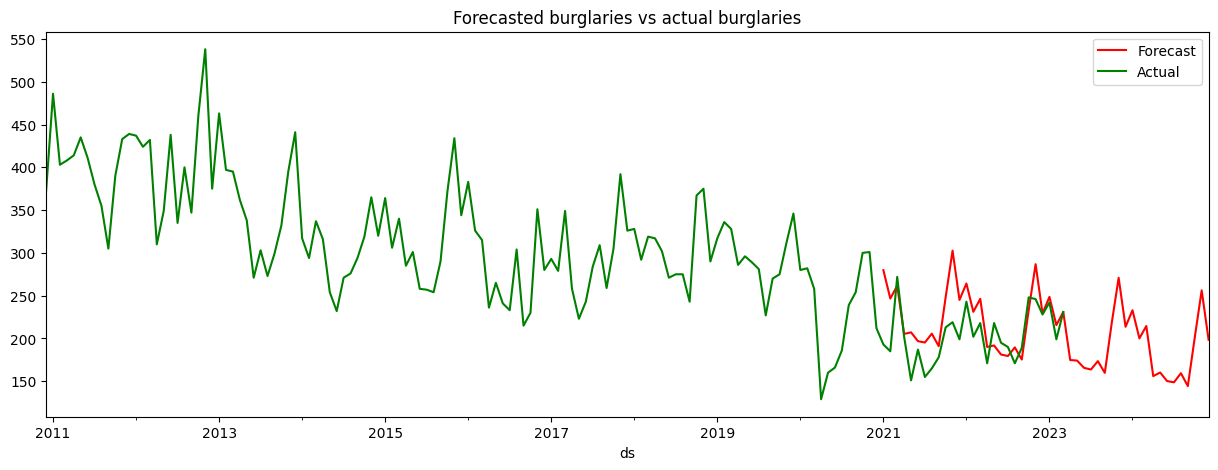

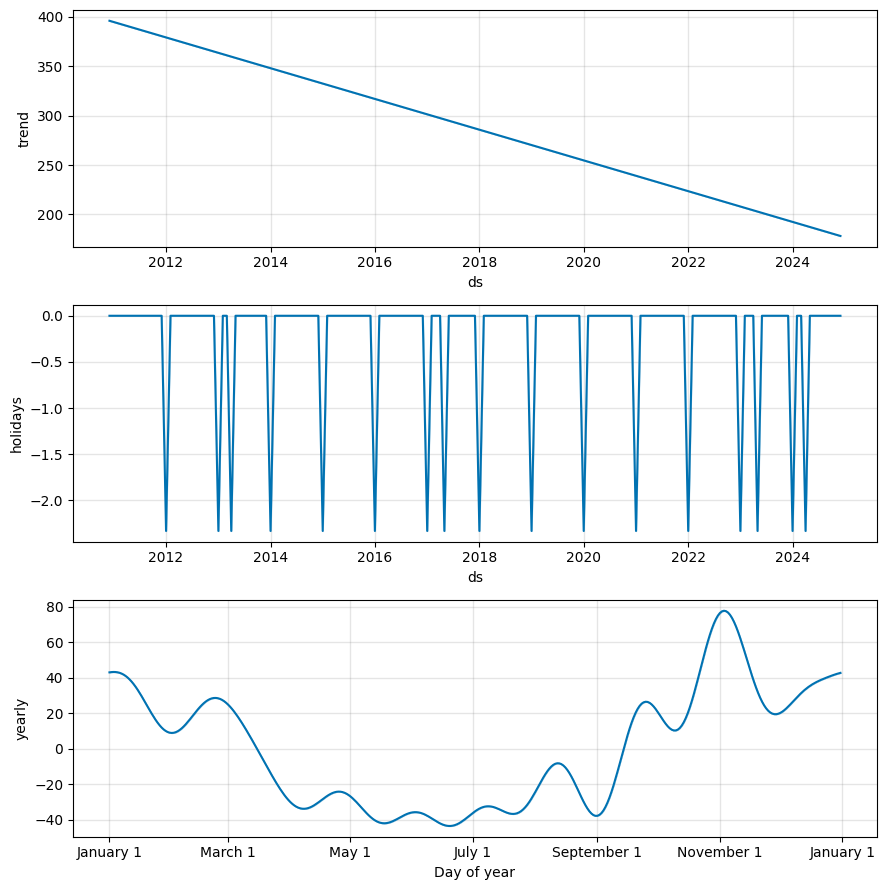

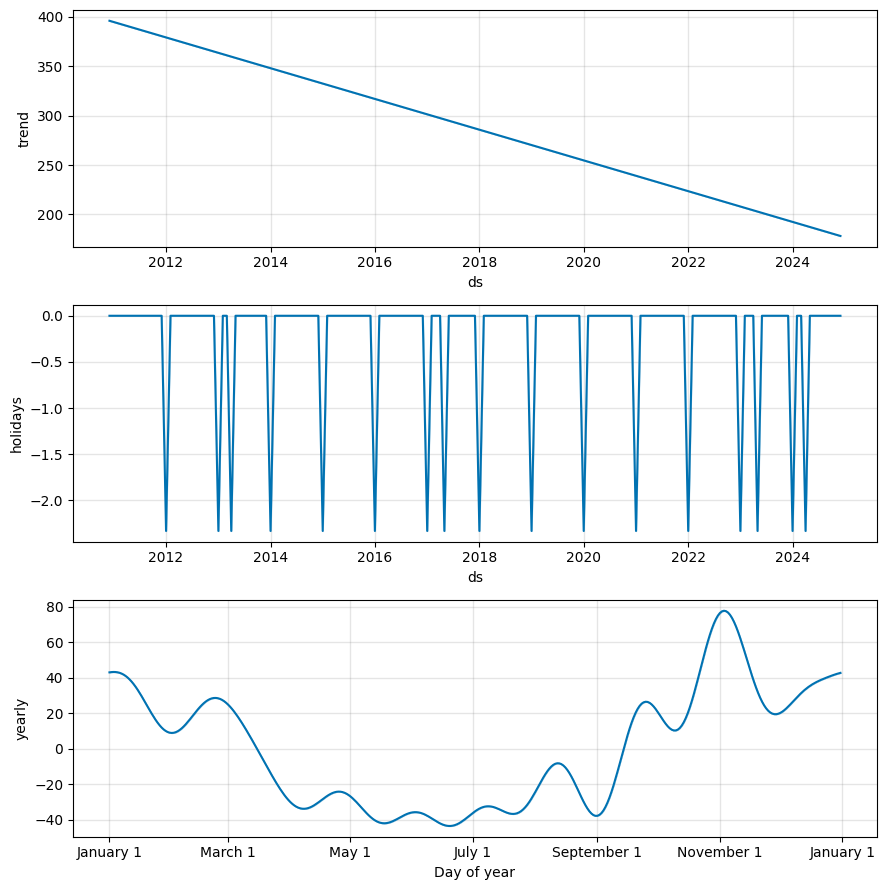

In [4]:
# Train the model with the best parameters and forecast

best_model = Prophet(seasonality_mode= 'additive', changepoint_prior_scale= 0.01, seasonality_prior_scale= 0.15, holidays_prior_scale= 0.015, holidays= holiday).fit(train_data)
future_dates = best_model.make_future_dataframe(periods=forecast_upto, freq='MS')
forecast = best_model.predict(future_dates)

# Plot predictions
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
forecast[-forecast_upto:].plot(kind='line',x='ds', y='yhat', color='red', label='Forecast', ax=ax)
monthly_grouped_df.plot(kind='line',x='ds',y='y', color='green',label='Actual', ax=ax)
plt.title('Forecasted burglaries vs actual burglaries')
plt.show()


best_model.plot_components(forecast)

In [31]:
#print(mean_absolute_error(test_data['y'], forecast['yhat'][-forecast_upto:]))
#r2_score(test_data['y'], forecast['yhat'][-forecast_upto:])

## Prediction per ward

In [5]:
# Create the dataframe
file =  pd.read_csv('C:/Users/20212828/Downloads/Bigfile/filtered_df_utility_cols.csv')
df_per_ward= file.sort_values(['Year','Month num'],ascending=False)
df_per_ward['Population per square kilometre'].fillna(0, inplace=True)
df_per_ward = df_per_ward.groupby(['Ward', 'Year', 'Month num', 'Population per square kilometre'])['Crime type'].count()
# Create a dataframe with the wanted dates
dates = pd.date_range(start='12/1/2010', end='12/31/2024', freq='MS').to_frame()
df_per_ward = df_per_ward.reset_index()
# Specify columns: ds, y, Date
df_per_ward['day'] = 1
df_per_ward = df_per_ward.reset_index()
df_per_ward['y'] = df_per_ward['Crime type']
df_per_ward = df_per_ward.rename(columns={'Month num': 'month', 'Year': 'year'})
df_per_ward['ds'] = pd.to_datetime(df_per_ward[['year', 'month', 'day']])
df_per_ward['Date'] = df_per_ward['ds']
dates['Date'] = dates[0]
dates = dates[['Date']]
print(df_per_ward.columns)

Index(['index', 'Ward', 'year', 'month', 'Population per square kilometre',
       'Crime type', 'day', 'y', 'ds', 'Date'],
      dtype='object')


In [6]:
wardlist = []
for ward in df_per_ward['Ward']:
    if ward not in wardlist:
        wardlist.append(ward)

print(wardlist)

['Barnet Vale', 'Brunswick Park', 'Burnt Oak', 'Childs Hill', 'Colindale North', 'Colindale South', 'Cricklewood', 'East Barnet', 'East Finchley', 'Edgware', 'Edgwarebury', 'Finchley Church End', 'Friern Barnet', 'Garden Suburb', 'Golders Green', 'Hendon', 'High Barnet', 'Mill Hill', 'Nan', 'Totteridge and Woodside', 'Underhill', 'West Finchley', 'West Hendon', 'Whetstone', 'Woodhouse']


In [7]:
original_unique_wards = file['Ward'].unique()
grouped_unique_wards = df_per_ward['Ward'].unique()

print("Original unique wards:", len(original_unique_wards))
print("Grouped unique wards:", len(grouped_unique_wards))

Original unique wards: 25
Grouped unique wards: 25


16:41:42 - cmdstanpy - INFO - Chain [1] start processing
16:41:42 - cmdstanpy - INFO - Chain [1] done processing


df ward             ds       Date  year   y  Population per square kilometre
0   2010-12-01 2010-12-01  2010  13                              0.0
1   2011-01-01 2011-01-01  2011  22                              0.0
2   2011-02-01 2011-02-01  2011  22                              0.0
3   2011-03-01 2011-03-01  2011  15                              0.0
4   2011-04-01 2011-04-01  2011  25                              0.0
..         ...        ...   ...  ..                              ...
143 2022-11-01 2022-11-01  2022   5                              0.0
144 2022-12-01 2022-12-01  2022   7                              0.0
145 2023-01-01 2023-01-01  2023   4                              0.0
146 2023-02-01 2023-02-01  2023   2                              0.0
147 2023-03-01 2023-03-01  2023   5                              0.0

[148 rows x 5 columns]
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')
            ds
0   2010-12-01
1   2011-01-01
2   2011-

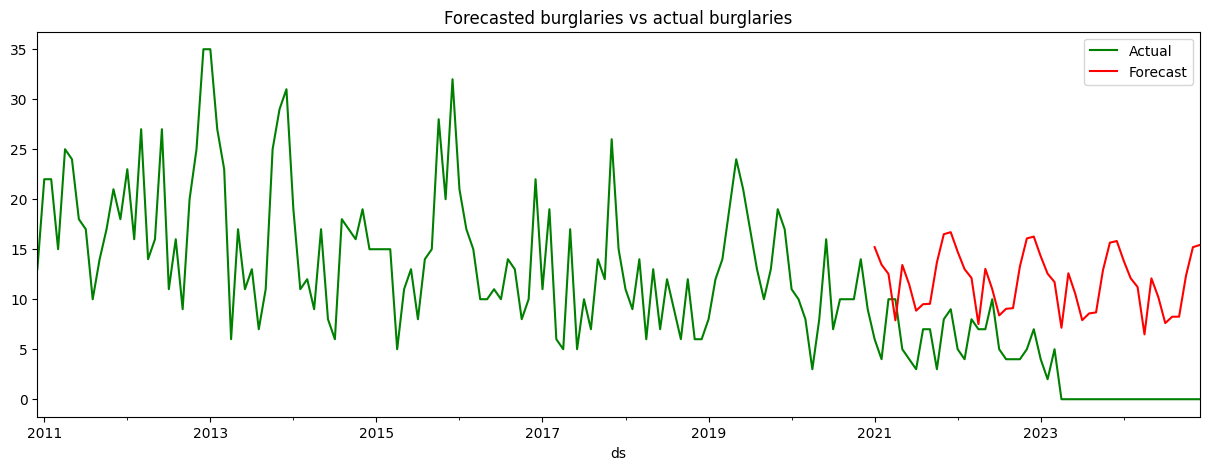

16:41:42 - cmdstanpy - INFO - Chain [1] start processing
16:41:42 - cmdstanpy - INFO - Chain [1] done processing


df ward             ds       Date  year   y  Population per square kilometre
148 2010-12-01 2010-12-01  2010  11                         0.000000
149 2011-01-01 2011-01-01  2011  14                      5183.994959
150 2011-02-01 2011-02-01  2011  21                      5183.994959
151 2011-03-01 2011-03-01  2011  12                      5183.994959
152 2011-04-01 2011-04-01  2011  14                      5183.994959
..         ...        ...   ...  ..                              ...
291 2022-11-01 2022-11-01  2022   4                      5288.909893
292 2022-12-01 2022-12-01  2022   4                      5288.909893
293 2023-01-01 2023-01-01  2023   6                      5278.512917
294 2023-02-01 2023-02-01  2023  14                      5278.512917
295 2023-03-01 2023-03-01  2023  13                      5278.512917

[148 rows x 5 columns]
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')
            ds
0   2010-12-01
1   2011-01-01
2   2011-

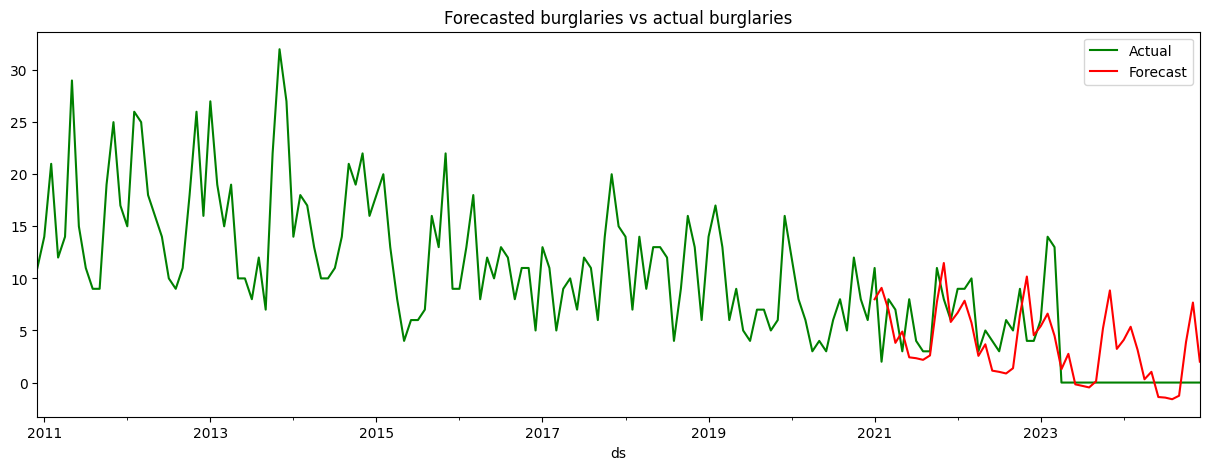

df ward             ds       Date  year   y  Population per square kilometre
296 2010-12-01 2010-12-01  2010  10                         0.000000
297 2011-01-01 2011-01-01  2011  14                      8856.104651
298 2011-02-01 2011-02-01  2011   9                      8856.104651
299 2011-03-01 2011-03-01  2011   5                      8856.104651
300 2011-04-01 2011-04-01  2011  12                      8856.104651
..         ...        ...   ...  ..                              ...
439 2022-11-01 2022-11-01  2022  15                      9787.790698
440 2022-12-01 2022-12-01  2022  14                      9787.790698
441 2023-01-01 2023-01-01  2023  11                      9746.608527
442 2023-02-01 2023-02-01  2023   5                      9746.608527
443 2023-03-01 2023-03-01  2023  11                      9746.608527

[148 rows x 5 columns]
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')


16:41:43 - cmdstanpy - INFO - Chain [1] start processing
16:41:43 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
164 2024-08-01
165 2024-09-01
166 2024-10-01
167 2024-11-01
168 2024-12-01

[169 rows x 1 columns]
Burnt Oak
-3.29483874603935


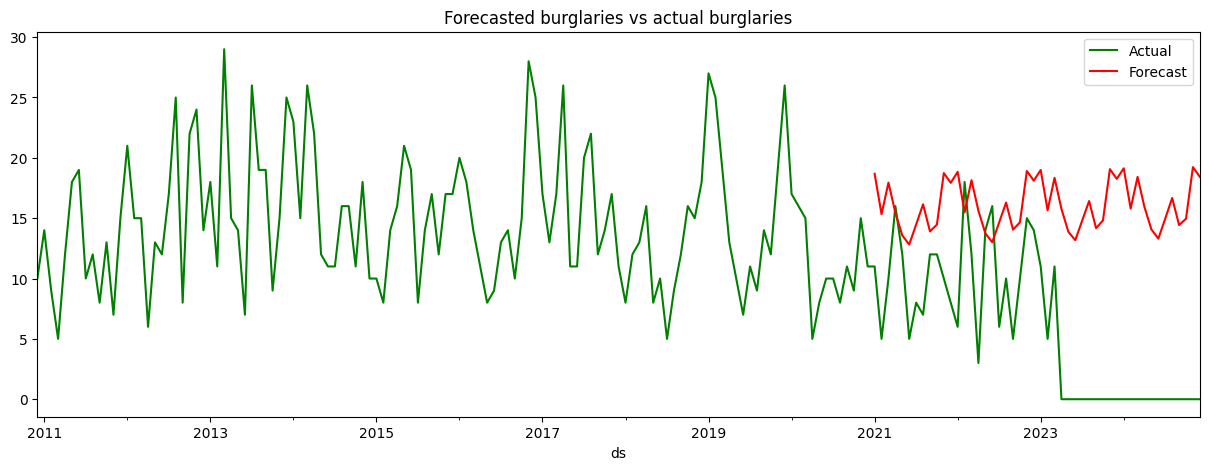

16:41:43 - cmdstanpy - INFO - Chain [1] start processing
16:41:43 - cmdstanpy - INFO - Chain [1] done processing


df ward             ds       Date  year   y  Population per square kilometre
444 2010-12-01 2010-12-01  2010  19                         0.000000
445 2011-01-01 2011-01-01  2011  39                      6510.844934
446 2011-02-01 2011-02-01  2011  22                      6510.844934
447 2011-03-01 2011-03-01  2011  32                      6510.844934
448 2011-04-01 2011-04-01  2011  31                      6510.844934
..         ...        ...   ...  ..                              ...
587 2022-11-01 2022-11-01  2022  31                      7399.805762
588 2022-12-01 2022-12-01  2022  21                      7399.805762
589 2023-01-01 2023-01-01  2023  22                      7400.129492
590 2023-02-01 2023-02-01  2023  21                      7400.129492
591 2023-03-01 2023-03-01  2023  19                      7400.129492

[148 rows x 5 columns]
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')
            ds
0   2010-12-01
1   2011-01-01
2   2011-

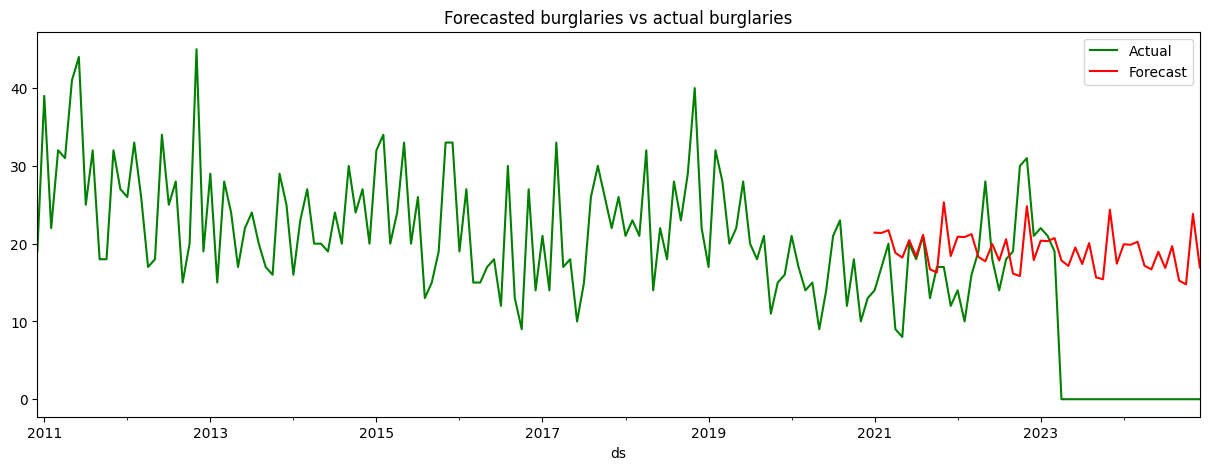

df ward             ds       Date  year   y  Population per square kilometre
592 2010-12-01 2010-12-01  2010   9                              0.0
593 2011-01-01 2011-01-01  2011   6                              0.0
594 2011-02-01 2011-02-01  2011   9                              0.0
595 2011-03-01 2011-03-01  2011  10                              0.0
596 2011-04-01 2011-04-01  2011   8                              0.0
..         ...        ...   ...  ..                              ...
735 2022-11-01 2022-11-01  2022   6                              0.0
736 2022-12-01 2022-12-01  2022   6                              0.0
737 2023-01-01 2023-01-01  2023   8                              0.0
738 2023-02-01 2023-02-01  2023   4                              0.0
739 2023-03-01 2023-03-01  2023  12                              0.0

[148 rows x 5 columns]
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')


16:41:44 - cmdstanpy - INFO - Chain [1] start processing
16:41:44 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
164 2024-08-01
165 2024-09-01
166 2024-10-01
167 2024-11-01
168 2024-12-01

[169 rows x 1 columns]
Colindale North
0.005493692312579235


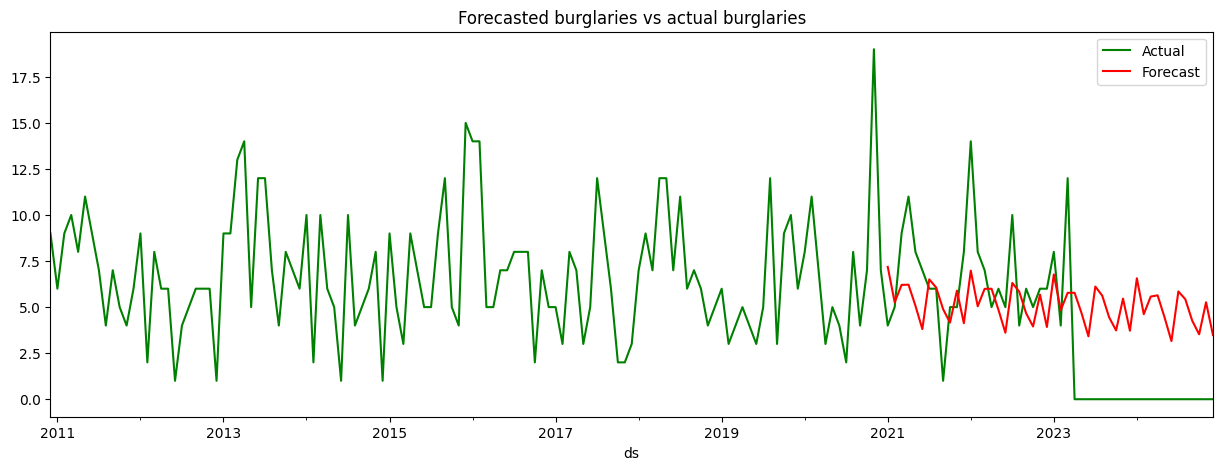

df ward             ds       Date  year   y  Population per square kilometre
740 2010-12-01 2010-12-01  2010   4                              0.0
741 2011-01-01 2011-01-01  2011   5                              0.0
742 2011-02-01 2011-02-01  2011   4                              0.0
743 2011-03-01 2011-03-01  2011   5                              0.0
744 2011-04-01 2011-04-01  2011   1                              0.0
..         ...        ...   ...  ..                              ...
882 2022-11-01 2022-11-01  2022   4                              0.0
883 2022-12-01 2022-12-01  2022  10                              0.0
884 2023-01-01 2023-01-01  2023  12                              0.0
885 2023-02-01 2023-02-01  2023   9                              0.0
886 2023-03-01 2023-03-01  2023   6                              0.0

[147 rows x 5 columns]
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')


16:41:44 - cmdstanpy - INFO - Chain [1] start processing
16:41:44 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
164 2024-08-01
165 2024-09-01
166 2024-10-01
167 2024-11-01
168 2024-12-01

[169 rows x 1 columns]
Colindale South
-0.4210147542950067


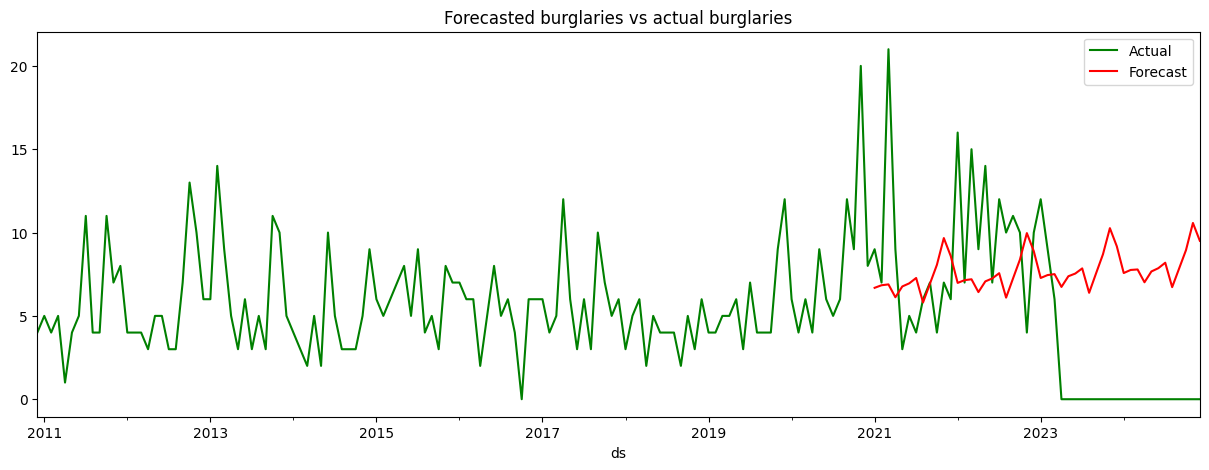

16:41:45 - cmdstanpy - INFO - Chain [1] start processing
16:41:45 - cmdstanpy - INFO - Chain [1] done processing


df ward              ds       Date  year   y  Population per square kilometre
887  2010-12-01 2010-12-01  2010  11                              0.0
888  2011-01-01 2011-01-01  2011  14                              0.0
889  2011-02-01 2011-02-01  2011  21                              0.0
890  2011-03-01 2011-03-01  2011  24                              0.0
891  2011-04-01 2011-04-01  2011  32                              0.0
...         ...        ...   ...  ..                              ...
1030 2022-11-01 2022-11-01  2022  17                              0.0
1031 2022-12-01 2022-12-01  2022  12                              0.0
1032 2023-01-01 2023-01-01  2023  12                              0.0
1033 2023-02-01 2023-02-01  2023  15                              0.0
1034 2023-03-01 2023-03-01  2023   9                              0.0

[148 rows x 5 columns]
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')
            ds
0   2010-12-01
1   2011-01-

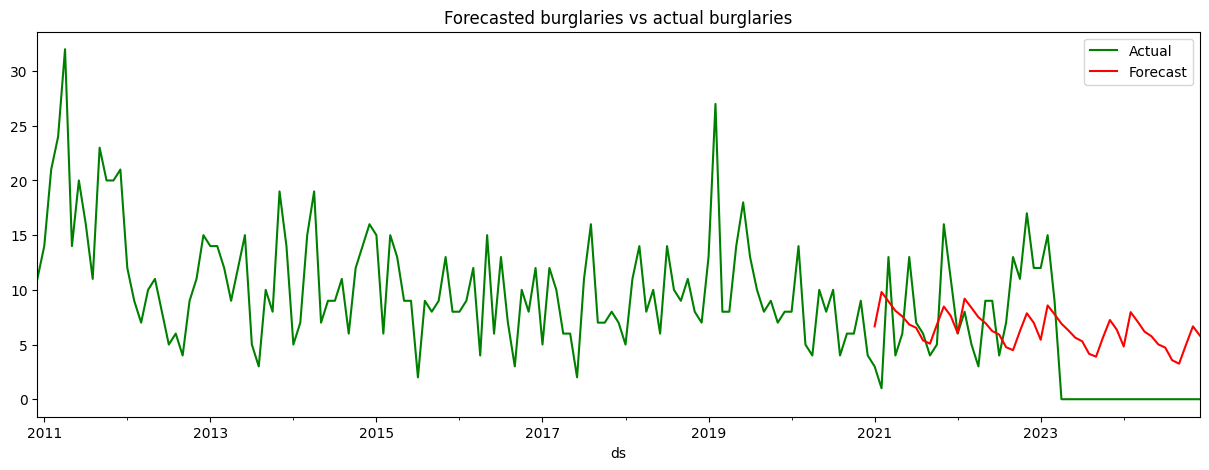

df ward              ds       Date  year   y  Population per square kilometre
1035 2010-12-01 2010-12-01  2010  18                         0.000000
1036 2011-01-01 2011-01-01  2011  21                      4316.364606
1037 2011-02-01 2011-02-01  2011  12                      4316.364606
1038 2011-03-01 2011-03-01  2011  14                      4316.364606
1039 2011-04-01 2011-04-01  2011  16                      4316.364606
...         ...        ...   ...  ..                              ...
1178 2022-11-01 2022-11-01  2022   5                      4736.407249
1179 2022-12-01 2022-12-01  2022  12                      4736.407249
1180 2023-01-01 2023-01-01  2023   9                      4793.443497
1181 2023-02-01 2023-02-01  2023   5                      4793.443497
1182 2023-03-01 2023-03-01  2023   8                      4793.443497

[148 rows x 5 columns]
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')


16:41:45 - cmdstanpy - INFO - Chain [1] start processing
16:41:45 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
164 2024-08-01
165 2024-09-01
166 2024-10-01
167 2024-11-01
168 2024-12-01

[169 rows x 1 columns]
East Barnet
0.3426477574626554


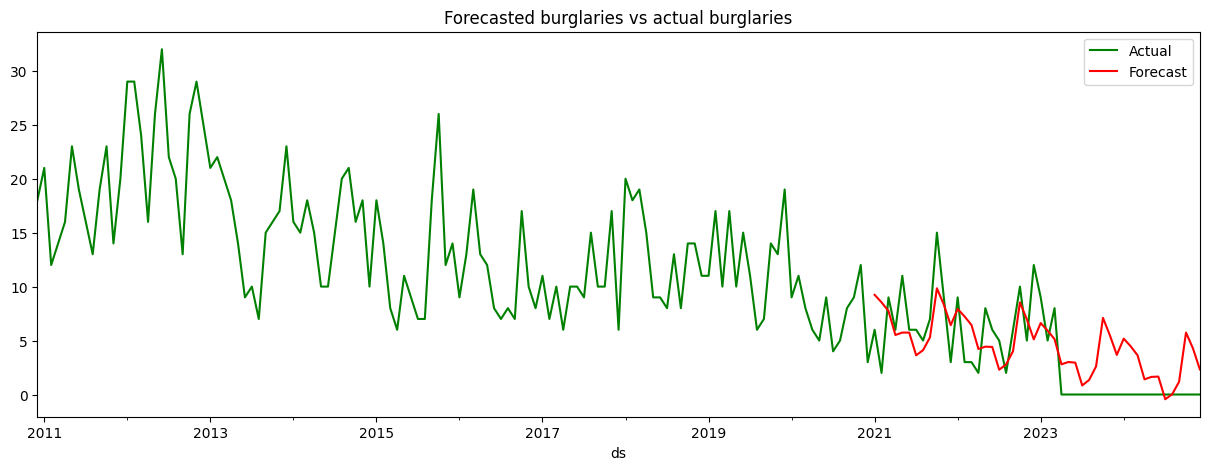

df ward              ds       Date  year   y  Population per square kilometre
1183 2010-12-01 2010-12-01  2010  17                         0.000000
1184 2011-01-01 2011-01-01  2011  19                      6358.954041
1185 2011-02-01 2011-02-01  2011  13                      6358.954041
1186 2011-03-01 2011-03-01  2011  14                      6358.954041
1187 2011-04-01 2011-04-01  2011   7                      6358.954041
...         ...        ...   ...  ..                              ...
1326 2022-11-01 2022-11-01  2022   3                      6841.521395
1327 2022-12-01 2022-12-01  2022   6                      6841.521395
1328 2023-01-01 2023-01-01  2023   4                      6799.920761
1329 2023-02-01 2023-02-01  2023   5                      6799.920761
1330 2023-03-01 2023-03-01  2023   9                      6799.920761

[148 rows x 5 columns]
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')


16:41:45 - cmdstanpy - INFO - Chain [1] start processing
16:41:45 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
164 2024-08-01
165 2024-09-01
166 2024-10-01
167 2024-11-01
168 2024-12-01

[169 rows x 1 columns]
East Finchley
-0.002607719115209184


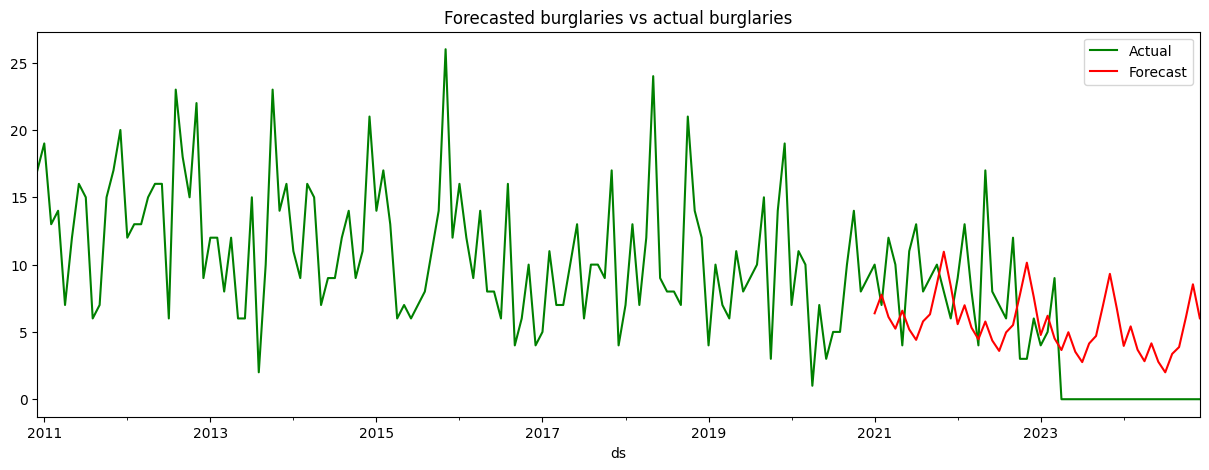

df ward              ds       Date  year   y  Population per square kilometre
1331 2010-12-01 2010-12-01  2010  22                         0.000000
1332 2011-01-01 2011-01-01  2011  13                      3019.244604
1333 2011-02-01 2011-02-01  2011  15                      3019.244604
1334 2011-03-01 2011-03-01  2011   4                      3019.244604
1335 2011-04-01 2011-04-01  2011  12                      3019.244604
...         ...        ...   ...  ..                              ...
1474 2022-11-01 2022-11-01  2022   9                      3883.273381
1475 2022-12-01 2022-12-01  2022  11                      3883.273381
1476 2023-01-01 2023-01-01  2023  11                      3928.417266
1477 2023-02-01 2023-02-01  2023  11                      3928.417266
1478 2023-03-01 2023-03-01  2023  11                      3928.417266

[148 rows x 5 columns]
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')


16:41:46 - cmdstanpy - INFO - Chain [1] start processing
16:41:46 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
164 2024-08-01
165 2024-09-01
166 2024-10-01
167 2024-11-01
168 2024-12-01

[169 rows x 1 columns]
Edgware
0.08912795357135617


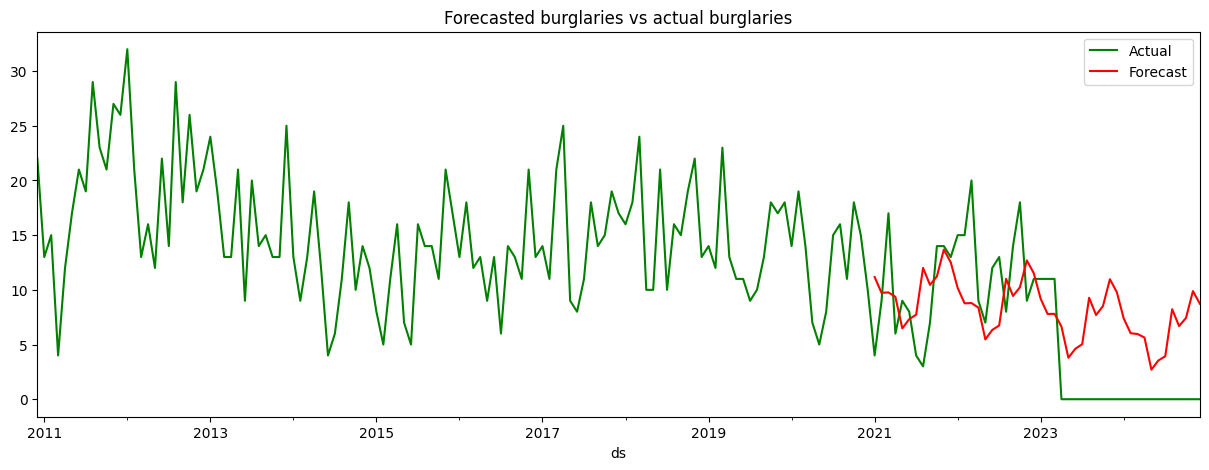

df ward              ds       Date  year   y  Population per square kilometre
1479 2010-12-01 2010-12-01  2010  17                              0.0
1480 2011-01-01 2011-01-01  2011  17                              0.0
1481 2011-02-01 2011-02-01  2011  13                              0.0
1482 2011-03-01 2011-03-01  2011   9                              0.0
1483 2011-04-01 2011-04-01  2011   5                              0.0
...         ...        ...   ...  ..                              ...
1619 2022-11-01 2022-11-01  2022   5                              0.0
1620 2022-12-01 2022-12-01  2022   5                              0.0
1621 2023-01-01 2023-01-01  2023   2                              0.0
1622 2023-02-01 2023-02-01  2023   4                              0.0
1623 2023-03-01 2023-03-01  2023   5                              0.0

[145 rows x 5 columns]
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')


16:41:46 - cmdstanpy - INFO - Chain [1] start processing
16:41:46 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
164 2024-08-01
165 2024-09-01
166 2024-10-01
167 2024-11-01
168 2024-12-01

[169 rows x 1 columns]
Edgwarebury
0.04521151732218387


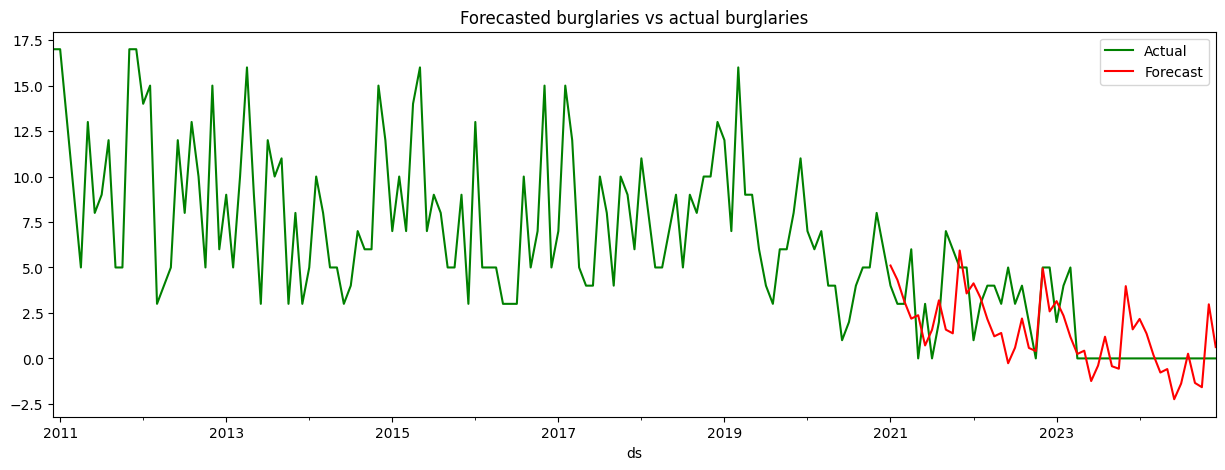

df ward              ds       Date  year   y  Population per square kilometre
1624 2010-12-01 2010-12-01  2010  21                         0.000000
1625 2011-01-01 2011-01-01  2011  22                      5824.289406
1626 2011-02-01 2011-02-01  2011  26                      5824.289406
1627 2011-03-01 2011-03-01  2011  25                      5824.289406
1628 2011-04-01 2011-04-01  2011  18                      5824.289406
...         ...        ...   ...  ..                              ...
1767 2022-11-01 2022-11-01  2022   9                      6310.446659
1768 2022-12-01 2022-12-01  2022  16                      6310.446659
1769 2023-01-01 2023-01-01  2023  11                      6295.681063
1770 2023-02-01 2023-02-01  2023  17                      6295.681063
1771 2023-03-01 2023-03-01  2023  18                      6295.681063

[148 rows x 5 columns]
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')


16:41:47 - cmdstanpy - INFO - Chain [1] start processing
16:41:47 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
164 2024-08-01
165 2024-09-01
166 2024-10-01
167 2024-11-01
168 2024-12-01

[169 rows x 1 columns]
Finchley Church End
-0.4459330375600914


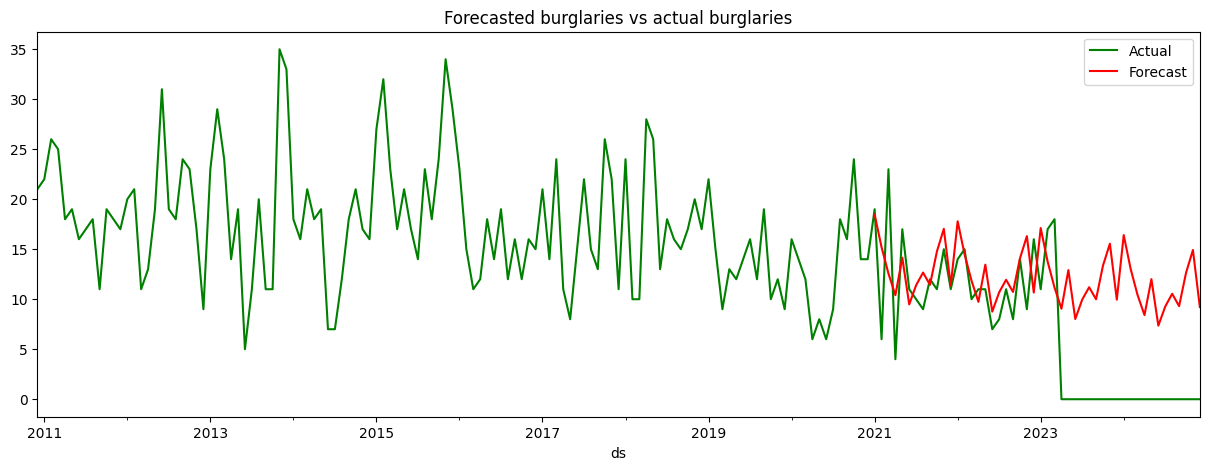

df ward              ds       Date  year   y  Population per square kilometre
1772 2010-12-01 2010-12-01  2010  19                              0.0
1773 2011-01-01 2011-01-01  2011  28                              0.0
1774 2011-02-01 2011-02-01  2011  28                              0.0
1775 2011-03-01 2011-03-01  2011  22                              0.0
1776 2011-04-01 2011-04-01  2011  18                              0.0
...         ...        ...   ...  ..                              ...
1915 2022-11-01 2022-11-01  2022   8                              0.0
1916 2022-12-01 2022-12-01  2022   4                              0.0
1917 2023-01-01 2023-01-01  2023  16                              0.0
1918 2023-02-01 2023-02-01  2023   4                              0.0
1919 2023-03-01 2023-03-01  2023   9                              0.0

[148 rows x 5 columns]
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')


16:41:47 - cmdstanpy - INFO - Chain [1] start processing
16:41:47 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
164 2024-08-01
165 2024-09-01
166 2024-10-01
167 2024-11-01
168 2024-12-01

[169 rows x 1 columns]
Friern Barnet
-0.40457083244741665


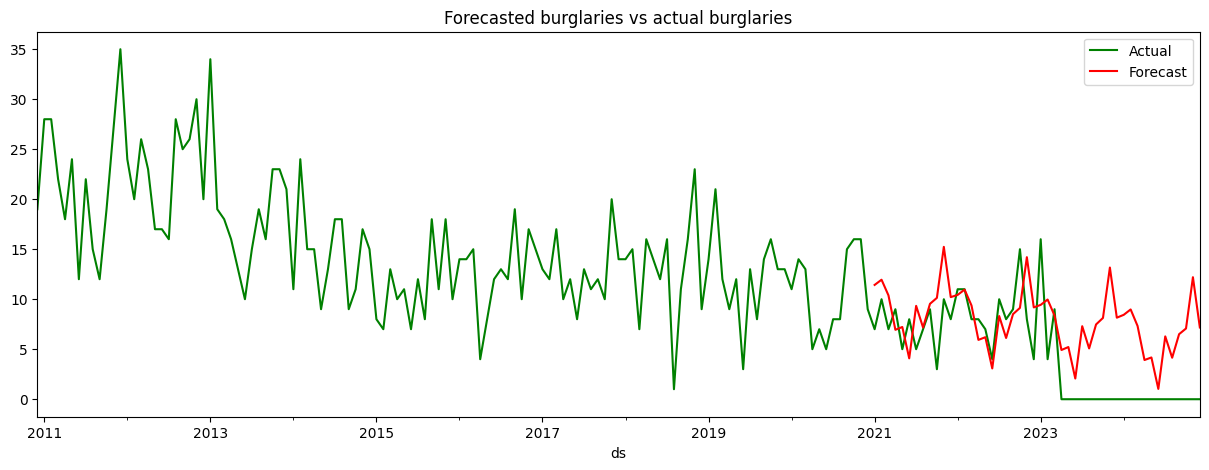

df ward              ds       Date  year   y  Population per square kilometre
1920 2010-12-01 2010-12-01  2010  12                         0.000000
1921 2011-01-01 2011-01-01  2011  32                      3379.835130
1922 2011-02-01 2011-02-01  2011  19                      3379.835130
1923 2011-03-01 2011-03-01  2011  23                      3379.835130
1924 2011-04-01 2011-04-01  2011  19                      3379.835130
...         ...        ...   ...  ..                              ...
2063 2022-11-01 2022-11-01  2022  12                      3557.598816
2064 2022-12-01 2022-12-01  2022   8                      3557.598816
2065 2023-01-01 2023-01-01  2023  10                      3546.818854
2066 2023-02-01 2023-02-01  2023   5                      3546.818854
2067 2023-03-01 2023-03-01  2023   9                      3546.818854

[148 rows x 5 columns]
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')


16:41:48 - cmdstanpy - INFO - Chain [1] start processing
16:41:48 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
164 2024-08-01
165 2024-09-01
166 2024-10-01
167 2024-11-01
168 2024-12-01

[169 rows x 1 columns]
Garden Suburb
-3.993725136832646


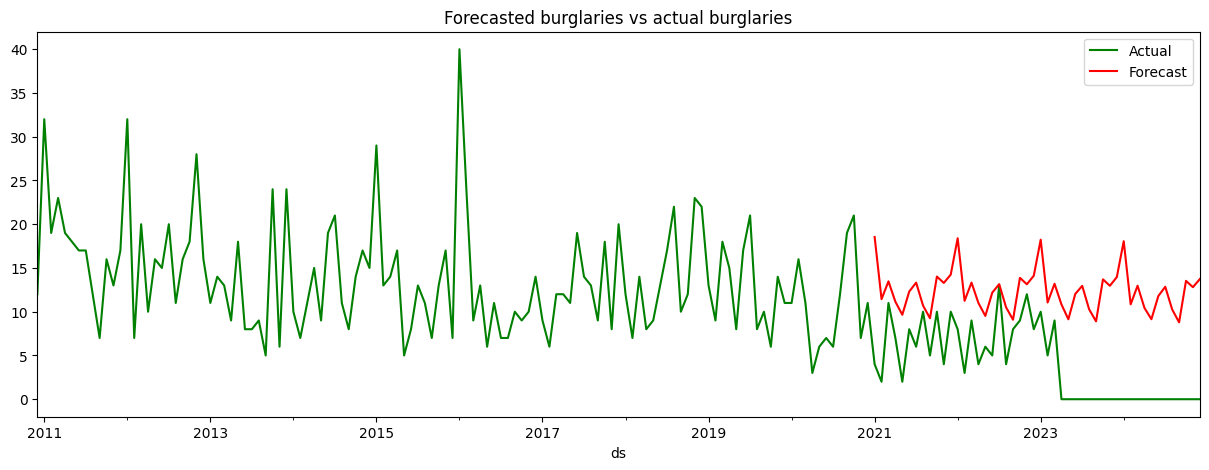

16:41:48 - cmdstanpy - INFO - Chain [1] start processing
16:41:48 - cmdstanpy - INFO - Chain [1] done processing


df ward              ds       Date  year   y  Population per square kilometre
2068 2010-12-01 2010-12-01  2010  13                         0.000000
2069 2011-01-01 2011-01-01  2011  22                      6339.825386
2070 2011-02-01 2011-02-01  2011  18                      6339.825386
2071 2011-03-01 2011-03-01  2011  25                      6339.825386
2072 2011-04-01 2011-04-01  2011  21                      6339.825386
...         ...        ...   ...  ..                              ...
2211 2022-11-01 2022-11-01  2022   8                      8054.063130
2212 2022-12-01 2022-12-01  2022   6                      8054.063130
2213 2023-01-01 2023-01-01  2023  11                      8309.267965
2214 2023-02-01 2023-02-01  2023   6                      8309.267965
2215 2023-03-01 2023-03-01  2023  12                      8309.267965

[148 rows x 5 columns]
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')
            ds
0   2010-12-01
1   2011-01-

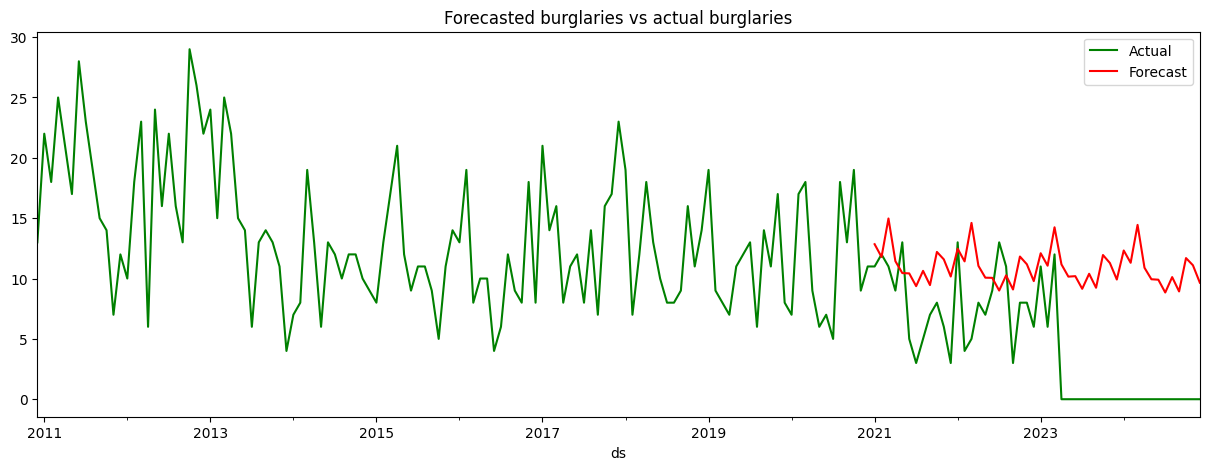

df ward              ds       Date  year   y  Population per square kilometre
2216 2010-12-01 2010-12-01  2010  34                         0.000000
2217 2011-01-01 2011-01-01  2011  30                      6522.887324
2218 2011-02-01 2011-02-01  2011  27                      6522.887324
2219 2011-03-01 2011-03-01  2011  41                      6522.887324
2220 2011-04-01 2011-04-01  2011  33                      6522.887324
...         ...        ...   ...  ..                              ...
2359 2022-11-01 2022-11-01  2022  18                      7098.239437
2360 2022-12-01 2022-12-01  2022  12                      7098.239437
2361 2023-01-01 2023-01-01  2023  15                      7063.732394
2362 2023-02-01 2023-02-01  2023  12                      7063.732394
2363 2023-03-01 2023-03-01  2023  14                      7063.732394

[148 rows x 5 columns]
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')


16:41:48 - cmdstanpy - INFO - Chain [1] start processing
16:41:48 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
164 2024-08-01
165 2024-09-01
166 2024-10-01
167 2024-11-01
168 2024-12-01

[169 rows x 1 columns]
Hendon
0.18617439937391622


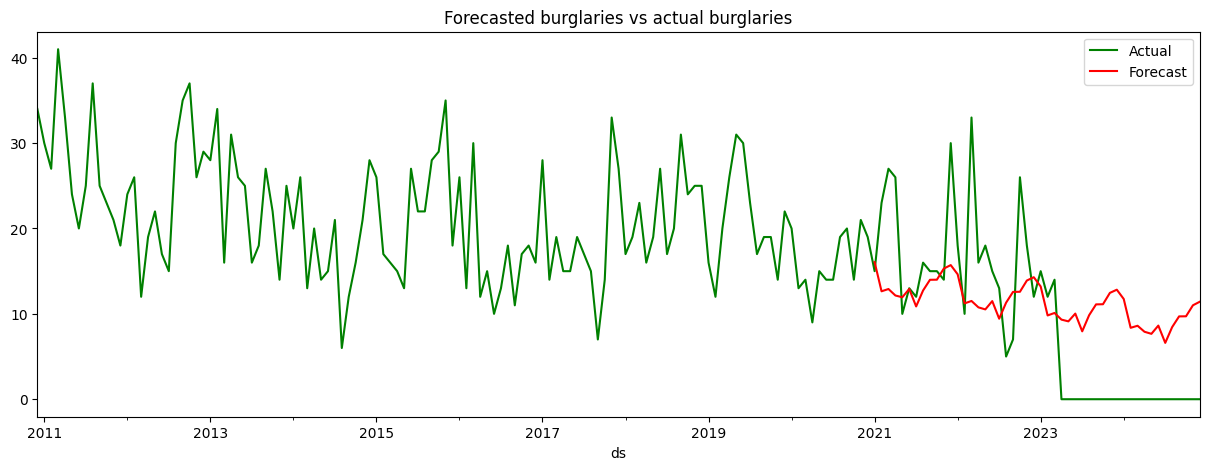

16:41:49 - cmdstanpy - INFO - Chain [1] start processing


df ward              ds       Date  year   y  Population per square kilometre
2364 2010-12-01 2010-12-01  2010  15                         0.000000
2365 2011-01-01 2011-01-01  2011  21                      1849.079312
2366 2011-02-01 2011-02-01  2011  13                      1849.079312
2367 2011-03-01 2011-03-01  2011  17                      1849.079312
2368 2011-04-01 2011-04-01  2011  20                      1849.079312
...         ...        ...   ...  ..                              ...
2506 2022-10-01 2022-10-01  2022   7                      1933.325310
2507 2022-11-01 2022-11-01  2022  11                      1933.325310
2508 2023-01-01 2023-01-01  2023   9                      1932.723553
2509 2023-02-01 2023-02-01  2023   6                      1932.723553
2510 2023-03-01 2023-03-01  2023   7                      1932.723553

[147 rows x 5 columns]
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')


16:41:49 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
164 2024-08-01
165 2024-09-01
166 2024-10-01
167 2024-11-01
168 2024-12-01

[169 rows x 1 columns]
High Barnet
0.01575010934359289


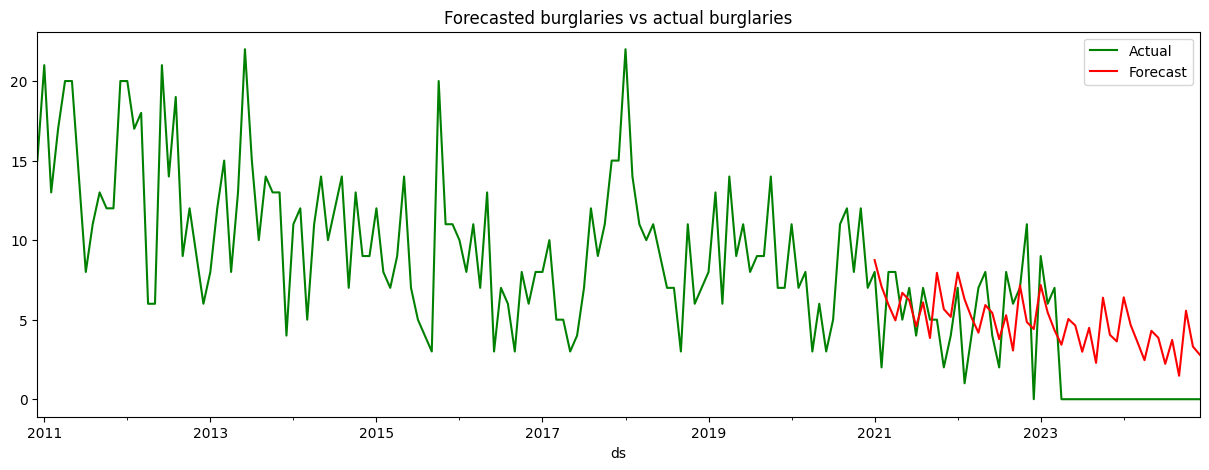

16:41:49 - cmdstanpy - INFO - Chain [1] start processing
16:41:49 - cmdstanpy - INFO - Chain [1] done processing


df ward              ds       Date  year   y  Population per square kilometre
2511 2010-12-01 2010-12-01  2010  29                         0.000000
2512 2011-01-01 2011-01-01  2011  32                      1973.260893
2513 2011-02-01 2011-02-01  2011  19                      1973.260893
2514 2011-03-01 2011-03-01  2011  25                      1973.260893
2515 2011-04-01 2011-04-01  2011  15                      1973.260893
...         ...        ...   ...  ..                              ...
2654 2022-11-01 2022-11-01  2022   8                      2728.560776
2655 2022-12-01 2022-12-01  2022  19                      2728.560776
2656 2023-01-01 2023-01-01  2023  16                      2854.799190
2657 2023-02-01 2023-02-01  2023  17                      2854.799190
2658 2023-03-01 2023-03-01  2023   7                      2854.799190

[148 rows x 5 columns]
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')
            ds
0   2010-12-01
1   2011-01-

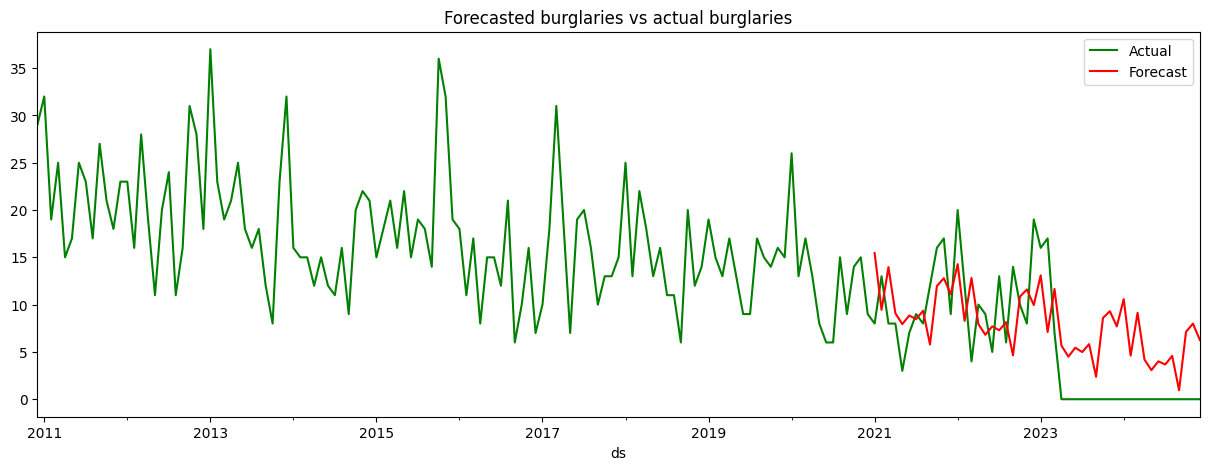

16:41:50 - cmdstanpy - INFO - Chain [1] start processing
16:41:50 - cmdstanpy - INFO - Chain [1] done processing


df ward              ds       Date  year   y  Population per square kilometre
2765 2010-12-01 2010-12-01  2010   7                              0.0
2766 2011-01-01 2011-01-01  2011  19                              0.0
2767 2011-02-01 2011-02-01  2011  13                              0.0
2768 2011-03-01 2011-03-01  2011  10                              0.0
2769 2011-04-01 2011-04-01  2011  21                              0.0
...         ...        ...   ...  ..                              ...
2907 2022-11-01 2022-11-01  2022  17                              0.0
2908 2022-12-01 2022-12-01  2022  16                              0.0
2909 2023-01-01 2023-01-01  2023  13                              0.0
2910 2023-02-01 2023-02-01  2023  11                              0.0
2911 2023-03-01 2023-03-01  2023  12                              0.0

[147 rows x 5 columns]
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')
            ds
0   2010-12-01
1   2011-01-

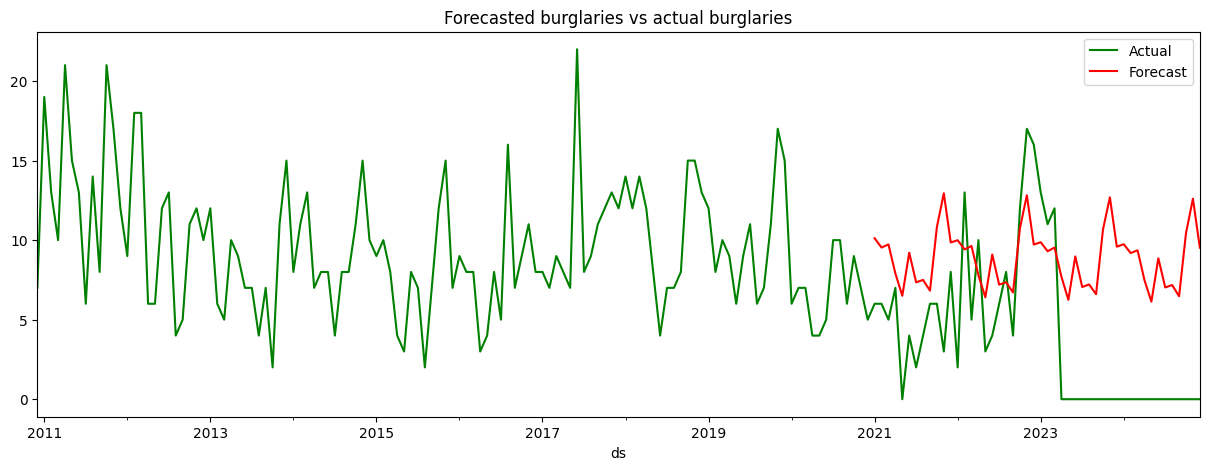

df ward              ds       Date  year   y  Population per square kilometre
2912 2010-12-01 2010-12-01  2010   7                         0.000000
2913 2011-01-01 2011-01-01  2011  16                      3510.105448
2914 2011-02-01 2011-02-01  2011   5                      3510.105448
2915 2011-03-01 2011-03-01  2011  22                      3510.105448
2916 2011-04-01 2011-04-01  2011  16                      3510.105448
...         ...        ...   ...  ..                              ...
3055 2022-11-01 2022-11-01  2022   5                      3644.991213
3056 2022-12-01 2022-12-01  2022   5                      3644.991213
3057 2023-01-01 2023-01-01  2023   6                      3645.650264
3058 2023-02-01 2023-02-01  2023   3                      3645.650264
3059 2023-03-01 2023-03-01  2023   2                      3645.650264

[148 rows x 5 columns]
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')


16:41:50 - cmdstanpy - INFO - Chain [1] start processing
16:41:50 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
164 2024-08-01
165 2024-09-01
166 2024-10-01
167 2024-11-01
168 2024-12-01

[169 rows x 1 columns]
Underhill
-11.828534026615928


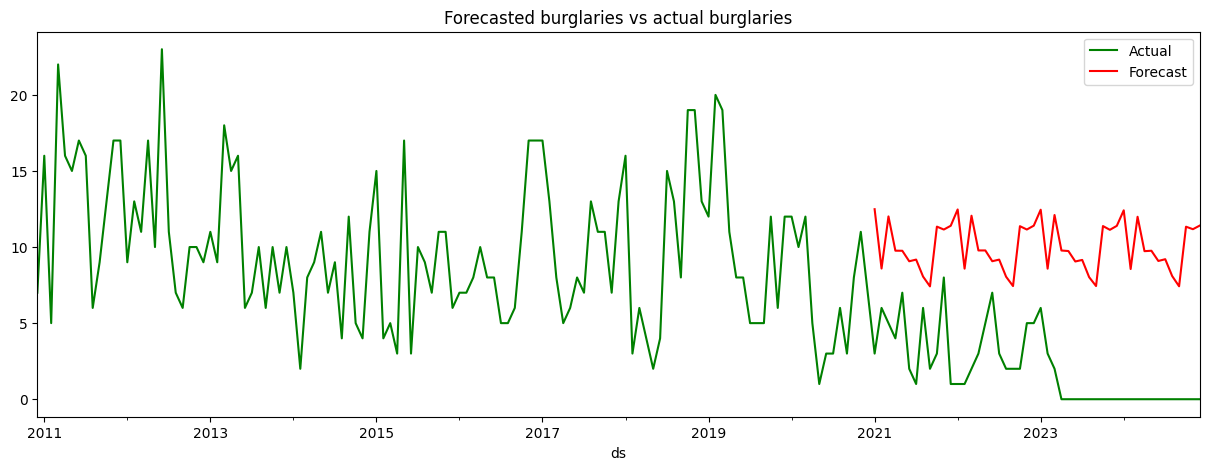

df ward              ds       Date  year   y  Population per square kilometre
3060 2010-12-01 2010-12-01  2010  27                         0.000000
3061 2011-01-01 2011-01-01  2011  28                      7678.852383
3062 2011-02-01 2011-02-01  2011  20                      7678.852383
3063 2011-03-01 2011-03-01  2011  21                      7678.852383
3064 2011-04-01 2011-04-01  2011  23                      7678.852383
...         ...        ...   ...  ..                              ...
3203 2022-11-01 2022-11-01  2022  13                      8234.150856
3204 2022-12-01 2022-12-01  2022   9                      8234.150856
3205 2023-01-01 2023-01-01  2023  17                      8210.550671
3206 2023-02-01 2023-02-01  2023   5                      8210.550671
3207 2023-03-01 2023-03-01  2023  13                      8210.550671

[148 rows x 5 columns]
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')


16:41:51 - cmdstanpy - INFO - Chain [1] start processing
16:41:51 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
164 2024-08-01
165 2024-09-01
166 2024-10-01
167 2024-11-01
168 2024-12-01

[169 rows x 1 columns]
West Finchley
0.4113179280609349


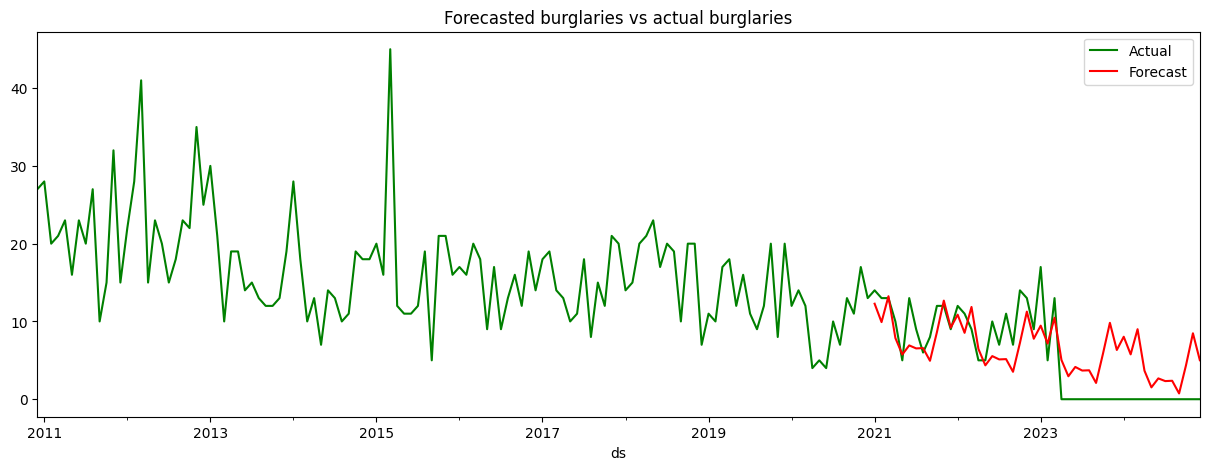

df ward              ds       Date  year   y  Population per square kilometre
3208 2010-12-01 2010-12-01  2010  15                         0.000000
3209 2011-01-01 2011-01-01  2011  17                      5094.570928
3210 2011-02-01 2011-02-01  2011  18                      5094.570928
3211 2011-03-01 2011-03-01  2011  10                      5094.570928
3212 2011-04-01 2011-04-01  2011  15                      5094.570928
...         ...        ...   ...  ..                              ...
3351 2022-11-01 2022-11-01  2022  10                      6206.946877
3352 2022-12-01 2022-12-01  2022   9                      6206.946877
3353 2023-01-01 2023-01-01  2023  11                      6242.848803
3354 2023-02-01 2023-02-01  2023   9                      6242.848803
3355 2023-03-01 2023-03-01  2023   8                      6242.848803

[148 rows x 5 columns]
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')


16:41:51 - cmdstanpy - INFO - Chain [1] start processing
16:41:51 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
164 2024-08-01
165 2024-09-01
166 2024-10-01
167 2024-11-01
168 2024-12-01

[169 rows x 1 columns]
West Hendon
-2.6539893743283867


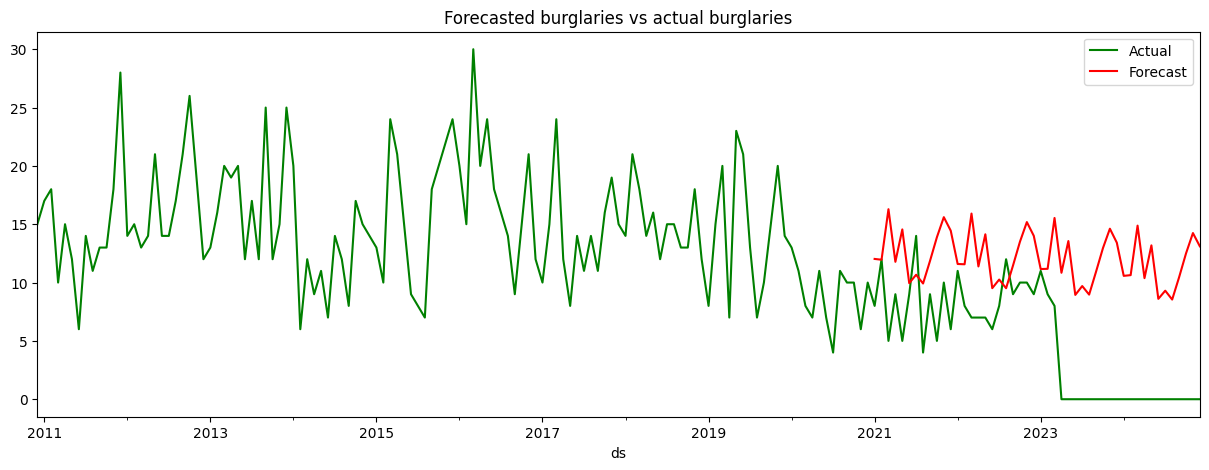

16:41:52 - cmdstanpy - INFO - Chain [1] start processing


df ward              ds       Date  year   y  Population per square kilometre
3356 2010-12-01 2010-12-01  2010   9                              0.0
3357 2011-01-01 2011-01-01  2011  12                              0.0
3358 2011-02-01 2011-02-01  2011  18                              0.0
3359 2011-03-01 2011-03-01  2011  18                              0.0
3360 2011-04-01 2011-04-01  2011  16                              0.0
...         ...        ...   ...  ..                              ...
3499 2022-11-01 2022-11-01  2022   8                              0.0
3500 2022-12-01 2022-12-01  2022   9                              0.0
3501 2023-01-01 2023-01-01  2023   1                              0.0
3502 2023-02-01 2023-02-01  2023   3                              0.0
3503 2023-03-01 2023-03-01  2023   4                              0.0

[148 rows x 5 columns]
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')


16:41:52 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
164 2024-08-01
165 2024-09-01
166 2024-10-01
167 2024-11-01
168 2024-12-01

[169 rows x 1 columns]
Whetstone
-2.7785478428398047


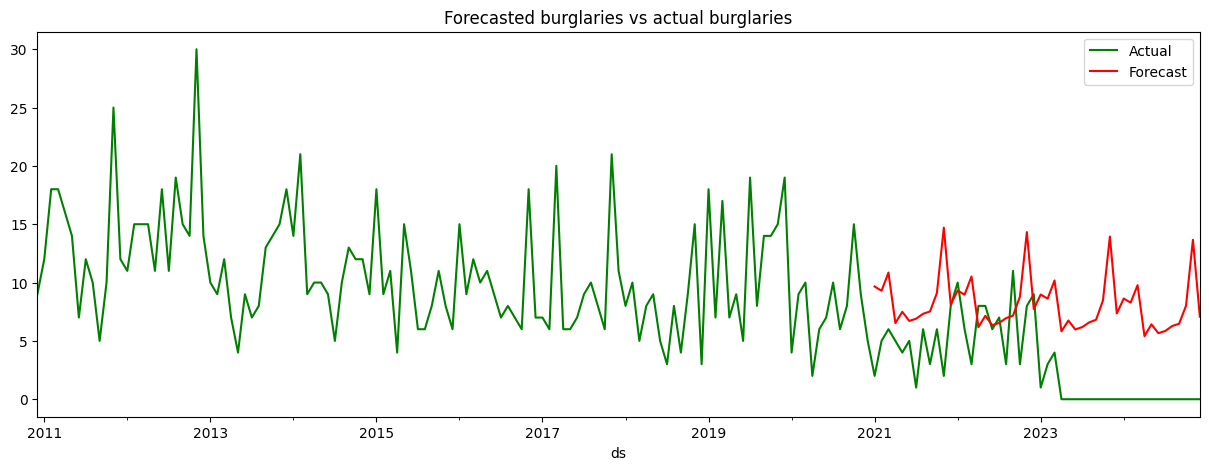

16:41:52 - cmdstanpy - INFO - Chain [1] start processing


df ward              ds       Date  year   y  Population per square kilometre
3504 2010-12-01 2010-12-01  2010  11                         0.000000
3505 2011-01-01 2011-01-01  2011  22                      6752.679939
3506 2011-02-01 2011-02-01  2011  18                      6752.679939
3507 2011-03-01 2011-03-01  2011   5                      6752.679939
3508 2011-04-01 2011-04-01  2011  12                      6752.679939
...         ...        ...   ...  ..                              ...
3647 2022-11-01 2022-11-01  2022  15                      7214.395100
3648 2022-12-01 2022-12-01  2022   7                      7214.395100
3649 2023-01-01 2023-01-01  2023   5                      7205.589587
3650 2023-02-01 2023-02-01  2023   6                      7205.589587
3651 2023-03-01 2023-03-01  2023   8                      7205.589587

[148 rows x 5 columns]
Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')


16:41:52 - cmdstanpy - INFO - Chain [1] done processing


            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
164 2024-08-01
165 2024-09-01
166 2024-10-01
167 2024-11-01
168 2024-12-01

[169 rows x 1 columns]
Woodhouse
-1.2025782198328598


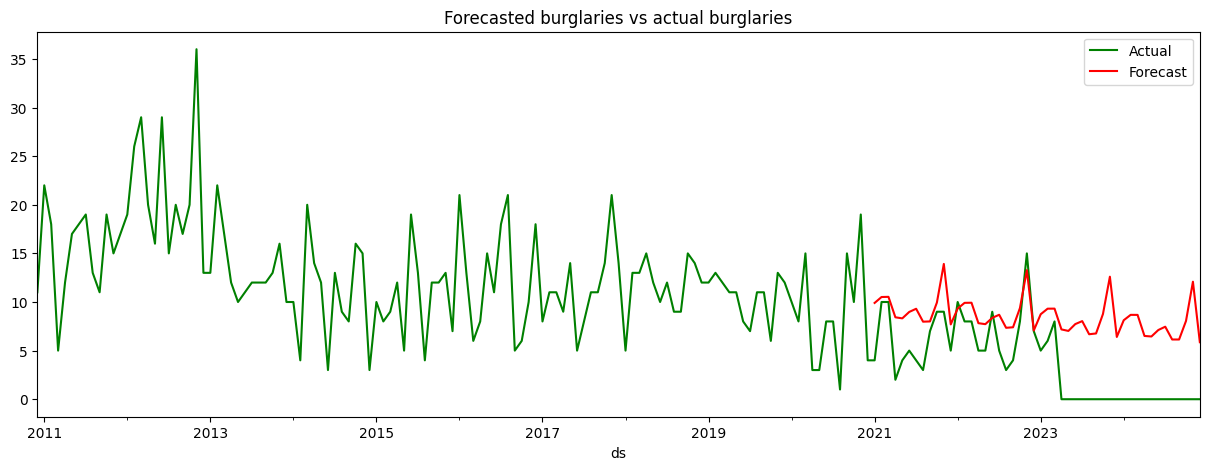

In [8]:
#print(df_per_ward)

# Get holiday dataset
holiday = pd.DataFrame([])
for date, name in sorted(holidays.country_holidays('GB', subdiv='England', years=[2012, 2013, 2014, 2015, 2016, 2017, 2018,2019,2020,2021, 2022, 2023, 2024]).items()):
    holiday= pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': "England-Holidays"}, index=[0])], ignore_index=True)

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

# Create a dataframe with the wanted dates
dates = pd.date_range(start='12/1/2010', end='12/31/2024', freq='MS').to_frame()

# Specify columns: ds, y, Date
df_per_ward['day'] = 1
df_per_ward = df_per_ward.reset_index()
df_per_ward = df_per_ward.rename(columns={'Month num': 'month', 'Year': 'year'})
df_per_ward['ds'] = pd.to_datetime(df_per_ward[['year', 'month', 'day']])
df_per_ward['Date'] = df_per_ward['ds']
dates['Date'] = dates[0]
dates = dates[['Date']]

# Loop over wards
wards = ['Barnet Vale', 'Brunswick Park', 'Burnt Oak', 'Childs Hill', 'Colindale North', 
         'Colindale South', 'Cricklewood', 'East Barnet', 'East Finchley', 'Edgware', 'Edgwarebury',
           'Finchley Church End', 'Friern Barnet', 'Garden Suburb', 'Golders Green', 'Hendon',
             'High Barnet', 'Mill Hill', 'Totteridge and Woodside', 
         'Underhill', 'West Finchley', 'West Hendon', 'Whetstone', 'Woodhouse']

for ward in wards: 
       # Select data of ward
       df_ward = df_per_ward[df_per_ward['Ward']==ward]
       df_ward = df_ward[['ds', 'Date', 'year', 'y', 'Population per square kilometre']]
       print('df ward', df_ward)
       # Merge with all dates to have a consistent dataframe
       df_ward = pd.merge(dates, df_ward, how="left", on='Date')
       df_ward['ds'] = df_ward['Date']
       df_ward['y'] = df_ward['y'].fillna(0)
       df_ward = df_ward.fillna(df_ward.mean())
       df_ward['year'] = pd.DatetimeIndex(df_ward['Date']).year
       train_ward = df_ward[df_ward['year']<(training_upto+1)]
       test_ward = df_ward[(df_ward['year']>training_upto)] 
       print(df_ward.columns)
       best_model = best_model = Prophet(seasonality_mode= 'additive', changepoint_prior_scale= 0.01, seasonality_prior_scale= 0.15, holidays_prior_scale= 0.015, holidays= holiday)
       best_model.add_regressor('Population per square kilometre')
       best_model.fit(train_ward)
       future_dates = best_model.make_future_dataframe(periods=forecast_upto, freq='MS')
       print(future_dates)
       future_dates = pd.merge(future_dates, df_ward, how="left", on='ds')
       forecast = best_model.predict(future_dates)
       print(ward)
       print(r2_score(test_ward[['y']], forecast['yhat'][-forecast_upto:]))
       f, ax = plt.subplots(figsize=(14,5))
       f.set_figheight(5)
       f.set_figwidth(15)
       
       df_ward.plot(kind='line',x='ds',y='y', color='green',label='Actual', ax=ax)
       forecast[-forecast_upto:].plot(kind='line',x='ds', y='yhat', color='red', label='Forecast', ax=ax)
       plt.title('Forecasted burglaries vs actual burglaries')
       plt.show()
       

16:41:58 - cmdstanpy - INFO - Chain [1] start processing
16:41:58 - cmdstanpy - INFO - Chain [1] done processing


Index(['Date', 'ds', 'year', 'y', 'Population per square kilometre'], dtype='object')
            ds
0   2010-12-01
1   2011-01-01
2   2011-02-01
3   2011-03-01
4   2011-04-01
..         ...
164 2024-08-01
165 2024-09-01
166 2024-10-01
167 2024-11-01
168 2024-12-01

[169 rows x 1 columns]
Brunswick Park
-1.2164321902208766


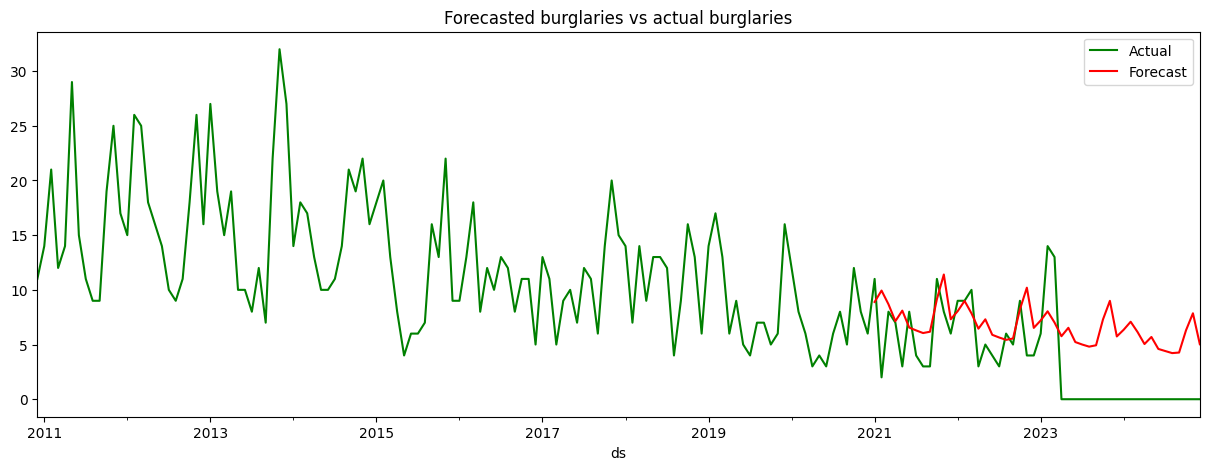

In [9]:
holiday = pd.DataFrame([])
for date, name in sorted(holidays.country_holidays('GB', subdiv='England', years=[2012, 2013, 2014, 2015, 2016, 2017, 2018,2019,2020,2021, 2022, 2023, 2024]).items()):
    holiday= pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': "England-Holidays"}, index=[0])], ignore_index=True)

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

ward = 'Brunswick Park'
df_ward = df_per_ward[df_per_ward['Ward']==ward]
df_ward = df_ward[['ds', 'Date', 'year', 'y', 'Population per square kilometre']]
df_ward = pd.merge(dates, df_ward, how="left", on='Date')
df_ward['ds'] = df_ward['Date']
df_ward['y'] = df_ward['y'].fillna(0)
df_ward = df_ward.fillna(df_ward.mean())
df_ward['year'] = pd.DatetimeIndex(df_ward['Date']).year
train_ward = df_ward[df_ward['year']<(training_upto+1)]
test_ward = df_ward[(df_ward['year']>training_upto)] 
print(df_ward.columns)
best_model = Prophet(seasonality_mode= 'multiplicative', changepoint_prior_scale= 0.01, seasonality_prior_scale= 0.15, holidays_prior_scale= 0.015, holidays= holiday)
best_model.add_regressor('Population per square kilometre')
best_model.fit(train_ward)
future_dates = best_model.make_future_dataframe(periods=forecast_upto, freq='MS')
print(future_dates)
future_dates = pd.merge(future_dates, df_ward, how="left", on='ds')
forecastward = best_model.predict(future_dates)
print(ward)
print(r2_score(test_ward[['y']], forecast['yhat'][-forecast_upto:]))
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)

df_ward.plot(kind='line',x='ds',y='y', color='green',label='Actual', ax=ax)
forecastward[-forecast_upto:].plot(kind='line',x='ds', y='yhat', color='red', label='Forecast', ax=ax)
plt.title('Forecasted burglaries vs actual burglaries')
plt.show()


In [10]:
import plotly.express as px

best_model = Prophet(seasonality_mode= 'multiplicative', changepoint_prior_scale= 0.01, seasonality_prior_scale= 0.15, holidays_prior_scale= 0.015, holidays= holiday).fit(train_data)
future_dates = best_model.make_future_dataframe(periods=forecast_upto, freq='MS')
forecast = best_model.predict(future_dates)

df_plot_pred = forecast[-forecast_upto:][['ds', 'yhat']]

df_plot_true = monthly_grouped_df[['ds', 'y']]

fig = px.line(df_plot_true, x='ds', y='y', title='Model predictions for Barnet')
fig.add_scatter(x=df_plot_pred['ds'], y=df_plot_pred['yhat'], name='Prediction')
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Number of Predicted Burglaries')

16:42:01 - cmdstanpy - INFO - Chain [1] start processing
16:42:01 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
filtered_df = pd.read_csv ('C:/Users/20212828/Downloads/Bigfile/filtered_df.csv')
filtered_df

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Ward new,Month num,Year,Month name
0,NaN,2010-12,Metropolitan Police Service,Metropolitan Police Service,-0.201877,51.655538,On or near High Street,E01000248,Barnet 001A,Burglary,High Barnet,12,2010,Dec
1,NaN,2010-12,Metropolitan Police Service,Metropolitan Police Service,-0.207853,51.654317,On or near The Avenue,E01000248,Barnet 001A,Burglary,High Barnet,12,2010,Dec
2,NaN,2010-12,Metropolitan Police Service,Metropolitan Police Service,-0.202510,51.656348,On or near Bruce Road,E01000248,Barnet 001A,Burglary,High Barnet,12,2010,Dec
3,NaN,2010-12,Metropolitan Police Service,Metropolitan Police Service,-0.206779,51.654768,On or near The Drive,E01000248,Barnet 001A,Burglary,High Barnet,12,2010,Dec
4,NaN,2010-12,Metropolitan Police Service,Metropolitan Police Service,-0.209537,51.655223,On or near Marriott Road,E01000249,Barnet 001B,Burglary,High Barnet,12,2010,Dec
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44133,fda0870be993d2c9352ae14a540bf529c15a7aa9d92a4e...,2023-03,Metropolitan Police Service,Metropolitan Police Service,-0.202163,51.559100,On or near Hocroft Road,E01000139,Barnet 041B,Burglary,Childs Hill,3,2023,Mar
44134,c6c2d9a772695865f4ca33fce59c26c48fe3a1cdac8c22...,2023-03,Metropolitan Police Service,Metropolitan Police Service,-0.202163,51.559100,On or near Hocroft Road,E01000139,Barnet 041B,Burglary,Childs Hill,3,2023,Mar
44135,e5bab2bd4f31de44515dbf125b85284392d0349139a1d3...,2023-03,Metropolitan Police Service,Metropolitan Police Service,-0.197843,51.561093,On or near Church Walk,E01000140,Barnet 041C,Burglary,Childs Hill,3,2023,Mar
44136,823465427f8764e250a48312715a4bd87e8012412046c6...,2023-03,Metropolitan Police Service,Metropolitan Police Service,-0.199449,51.563896,On or near Llanelly Road,E01000140,Barnet 041C,Burglary,Childs Hill,3,2023,Mar


In [12]:
#filtered_df = filtered_df[filtered_df['Ward new'].notna()]
#filtered_df = filtered_df.drop(filtered_df[filtered_df['Ward new'] == 'Nan'].index, inplace = True)
df_bar = filtered_df['Ward new'].value_counts()

figure1 = px.bar(df_bar, title="Number of burglaries by ward between Dec 2010 and March 2023")
figure1.update_layout(
    xaxis_title="Ward",
    yaxis_title="Number of burglaries")
figure1.update_xaxes(tickangle=90)
figure1.show()

In [13]:
wards = ['Barnet Vale', 'Brunswick Park', 'Burnt Oak', 'Childs Hill', 'Colindale North', 
         'Colindale South', 'Cricklewood', 'East Barnet', 'East Finchley', 'Edgware', 'Edgwarebury',
           'Finchley Church End', 'Friern Barnet', 'Garden Suburb', 'Golders Green', 'Hendon',
             'High Barnet', 'Mill Hill', 'Totteridge and Woodside', 
         'Underhill', 'West Finchley', 'West Hendon', 'Whetstone', 'Woodhouse']

In [14]:
holiday = pd.DataFrame([])
for date, name in sorted(holidays.country_holidays('GB', subdiv='England', years=[2012, 2013, 2014, 2015, 2016, 2017, 2018,2019,2020,2021, 2022, 2023, 2024]).items()):
    holiday= pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': "England-Holidays"}, index=[0])], ignore_index=True)

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

ward = 'Brunswick Park'
df_ward = df_per_ward[df_per_ward['Ward']==ward]
df_ward = df_ward[['ds', 'Date', 'year', 'y', 'Population per square kilometre']]
df_ward = pd.merge(dates, df_ward, how="left", on='Date')
df_ward['ds'] = df_ward['Date']
df_ward['y'] = df_ward['y'].fillna(0)
df_ward = df_ward.fillna(df_ward.mean())
df_ward['year'] = pd.DatetimeIndex(df_ward['Date']).year
train_ward = df_ward[df_ward['year']<(training_upto+1)]
test_ward = df_ward[(df_ward['year']>training_upto)] 
#print((df_ward['Population'].isnull().sum()))
#print(df_ward.columns)
best_model = Prophet(seasonality_mode= 'multiplicative', changepoint_prior_scale= 0.01, seasonality_prior_scale= 0.15, holidays_prior_scale= 0.015, holidays= holiday)
best_model.add_regressor('Population per square kilometre')
best_model.fit(train_ward)
future_dates = best_model.make_future_dataframe(periods=forecast_upto, freq='MS')
#print(future_dates)
future_dates = pd.merge(future_dates, df_ward, how="left", on='ds')
forecastward = best_model.predict(future_dates)
#print(ward)
#print(r2_score(test_ward[['y']], forecast['yhat'][-forecast_upto:]))

df_ward_true = df_ward[['ds', 'y']]
df_ward_true = df_ward_true[(df_ward_true != 0).all(1)]


df_ward_pred = forecastward[-forecast_upto:][['ds', 'yhat']]

figward = px.line(df_ward_true, x='ds', y='y', title='Model predictions for specific ward in Barnet')
figward.add_scatter(x=df_ward_pred['ds'], y=df_ward_pred['yhat'], name='Prediction')
figward.update_xaxes(title_text='Date')
figward.update_yaxes(title_text='Number of Predicted Burglaries')

16:42:13 - cmdstanpy - INFO - Chain [1] start processing
16:42:13 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
filtered_df_new = pd.read_csv('C:/Users/20212828/Downloads/Bigfile/filtered_df_utility_cols.csv')

fig_w = px.line(filtered_df_new.groupby(['Ward', 'Year']).size().reset_index(name='Burglary Rate'), x='Year', y='Burglary Rate', color='Ward',
                   title="Seasonal Plot: Ward Burglary Cases Growth")
fig_w.update_yaxes(title="Number of Cases")
fig_w.update_traces(mode="markers+lines", hovertemplate=None)
fig_w.update_layout(hovermode="x unified")

fig_w.show()

In [16]:
#dateselect = '2023-05-01'
#burglariesdf = df_ward_future_pred[df_ward_future_pred['ds'] == dateselect]
#burglaries = burglariesdf['yhat'].iloc[0]
#burglaries


In [23]:
file =  pd.read_csv('C:/Users/20212828/Downloads/Bigfile/filtered_df_utility_cols.csv')
df_per_ward= file.sort_values(['Year','Month num'],ascending=False)
df_per_ward['Population per square kilometre'].fillna(0, inplace=True)
df_per_ward = df_per_ward.groupby(['Ward', 'Year', 'Month num', 'Population per square kilometre'])['Crime type'].count()
# Create a dataframe with the wanted dates
dates = pd.date_range(start='12/1/2010', end='12/31/2024', freq='MS').to_frame()
df_per_ward = df_per_ward.reset_index()
# Specify columns: ds, y, Date
df_per_ward['day'] = 1
df_per_ward = df_per_ward.reset_index()
df_per_ward['y'] = df_per_ward['Crime type']
df_per_ward = df_per_ward.rename(columns={'Month num': 'month', 'Year': 'year'})
df_per_ward['ds'] = pd.to_datetime(df_per_ward[['year', 'month', 'day']])
df_per_ward['Date'] = df_per_ward['ds']
dates['Date'] = dates[0]
dates = dates[['Date']]

# Get holiday dataset
holiday = pd.DataFrame([])
for date, name in sorted(holidays.country_holidays('GB', subdiv='England', years=[2012, 2013, 2014, 2015, 2016, 2017, 2018,2019,2020,2021, 2022, 2023]).items()):
    holiday= pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': "England-Holidays"}, index=[0])], ignore_index=True)

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

# Create a dataframe with the wanted dates
dates = pd.date_range(start='12/1/2010', end='12/31/2024', freq='MS').to_frame()

# Specify columns: ds, y, Date
df_per_ward['day'] = 1
df_per_ward = df_per_ward.reset_index()
df_per_ward = df_per_ward.rename(columns={'Month num': 'month', 'Year': 'year'})
df_per_ward['ds'] = pd.to_datetime(df_per_ward[['year', 'month', 'day']])
df_per_ward['Date'] = df_per_ward['ds']
dates['Date'] = dates[0]
dates = dates[['Date']]

# Loop over wards
wards = ['Barnet Vale', 'Brunswick Park', 'Burnt Oak', 'Childs Hill', 'Colindale North', 
         'Colindale South', 'Cricklewood', 'East Barnet', 'East Finchley', 'Edgware', 'Edgwarebury',
           'Finchley Church End', 'Friern Barnet', 'Garden Suburb', 'Golders Green', 'Hendon',
             'High Barnet', 'Mill Hill', 'Totteridge and Woodside', 
         'Underhill', 'West Finchley', 'West Hendon', 'Whetstone', 'Woodhouse']


In [21]:

# Read data, get dataframe with crimes/month
monthly_grouped_df = pd.read_csv('C:/Users/20212828/Downloads/Bigfile/filtered_df_utility_cols.csv')
monthly_grouped_df= monthly_grouped_df.sort_values(['Year','Month num'],ascending=False).groupby(['Year', 'Month num'])['Crime type'].count()
monthly_grouped_df = monthly_grouped_df.to_frame()


# Rename columns, select rows with data and set datetime index
monthly_grouped_df = monthly_grouped_df.rename(columns = {'Month num':'y'})
monthly_grouped_df['day'] = 1
monthly_grouped_df = monthly_grouped_df.reset_index()
# monthly_grouped_df = monthly_grouped_df[(monthly_grouped_df['Year']>=2011) | ((monthly_grouped_df['Year'] == 2010) & (monthly_grouped_df['Month num']==12))]
monthly_grouped_df = monthly_grouped_df.rename(columns={'Month num': 'month', 'Year': 'year'})
monthly_grouped_df['ds'] = pd.to_datetime(monthly_grouped_df[['year', 'month', 'day']])
monthly_grouped_df['y'] = monthly_grouped_df['Crime type']
# monthly_grouped_df = monthly_grouped_df.set_index(pd.DatetimeIndex(monthly_grouped_df['Date']))

In [26]:
# Read data, get dataframe with crimes/month
monthly_grouped_df = pd.read_csv('C:/Users/20212828/Downloads/Bigfile/filtered_df_utility_cols.csv')
monthly_grouped_df= monthly_grouped_df.sort_values(['Year','Month num'],ascending=False).groupby(['Year', 'Month num'])['Crime type'].count()
monthly_grouped_df = monthly_grouped_df.to_frame()


# Rename columns, select rows with data and set datetime index
monthly_grouped_df = monthly_grouped_df.rename(columns = {'Month num':'y'})
monthly_grouped_df['day'] = 1
monthly_grouped_df = monthly_grouped_df.reset_index()
# monthly_grouped_df = monthly_grouped_df[(monthly_grouped_df['Year']>=2011) | ((monthly_grouped_df['Year'] == 2010) & (monthly_grouped_df['Month num']==12))]
monthly_grouped_df = monthly_grouped_df.rename(columns={'Month num': 'month', 'Year': 'year'})
monthly_grouped_df['ds'] = pd.to_datetime(monthly_grouped_df[['year', 'month', 'day']])
monthly_grouped_df['y'] = monthly_grouped_df['Crime type']
# monthly_grouped_df = monthly_grouped_df.set_index(pd.DatetimeIndex(monthly_grouped_df['Date']))

# Getting Holidays
holiday = pd.DataFrame([])
for date, name in sorted(holidays.country_holidays('GB', subdiv='England', years=[2012, 2013, 2014, 2015, 2016, 2017, 2018,2019,2020,2021, 2022, 2023, 2024]).items()):
#holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "England-Holidays"}, index=[0]), ignore_index=True)
        holiday= pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': "England-Holidays"}, index=[0])], ignore_index=True)

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

# Divide test and train data
train_data = monthly_grouped_df[monthly_grouped_df['year']<(training_upto+1)]
test_data = monthly_grouped_df[(monthly_grouped_df['year']>training_upto)]

best_model = Prophet(seasonality_mode= 'multiplicative', changepoint_prior_scale= 0.01, seasonality_prior_scale= 0.15, holidays_prior_scale= 0.015, holidays= holiday).fit(train_data)
future_dates = best_model.make_future_dataframe(periods=forecast_upto, freq='MS')
forecast = best_model.predict(future_dates)

df_plot_pred = forecast[-forecast_upto:][['ds', 'yhat']]

df_plot_pred = df_plot_pred[df_plot_pred['ds'] > '2022-12-31']
df_plot_pred = df_plot_pred.reset_index()
df_plot_pred = df_plot_pred.drop(['index'], axis=1)

# Create the dataframe
file =  pd.read_csv('C:/Users/20212828/Downloads/Bigfile/filtered_df_utility_cols.csv')
df_per_ward= file.sort_values(['Year','Month num'],ascending=False)
df_per_ward['Population per square kilometre'].fillna(0, inplace=True)
df_per_ward = df_per_ward.groupby(['Ward', 'Year', 'Month num', 'Population per square kilometre'])['Crime type'].count()
# Create a dataframe with the wanted dates
dates = pd.date_range(start='12/1/2010', end='12/31/2024', freq='MS').to_frame()
df_per_ward = df_per_ward.reset_index()
# Specify columns: ds, y, Date
df_per_ward['day'] = 1
df_per_ward = df_per_ward.reset_index()
df_per_ward['y'] = df_per_ward['Crime type']
df_per_ward = df_per_ward.rename(columns={'Month num': 'month', 'Year': 'year'})
df_per_ward['ds'] = pd.to_datetime(df_per_ward[['year', 'month', 'day']])
df_per_ward['Date'] = df_per_ward['ds']
dates['Date'] = dates[0]
dates = dates[['Date']]

# Get holiday dataset
holiday = pd.DataFrame([])
for date, name in sorted(holidays.country_holidays('GB', subdiv='England', years=[2012, 2013, 2014, 2015, 2016, 2017, 2018,2019,2020,2021, 2022, 2023, 2024]).items()):
    holiday= pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': "England-Holidays"}, index=[0])], ignore_index=True)

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

# Create a dataframe with the wanted dates
dates = pd.date_range(start='12/1/2010', end='12/31/2024', freq='MS').to_frame()

# Specify columns: ds, y, Date
df_per_ward['day'] = 1
df_per_ward = df_per_ward.reset_index()
df_per_ward = df_per_ward.rename(columns={'Month num': 'month', 'Year': 'year'})
df_per_ward['ds'] = pd.to_datetime(df_per_ward[['year', 'month', 'day']])
df_per_ward['Date'] = df_per_ward['ds']
dates['Date'] = dates[0]
dates = dates[['Date']]

# Loop over wards
wards = ['Barnet Vale', 'Brunswick Park', 'Burnt Oak', 'Childs Hill', 'Colindale North', 
         'Colindale South', 'Cricklewood', 'East Barnet', 'East Finchley', 'Edgware', 'Edgwarebury',
           'Finchley Church End', 'Friern Barnet', 'Garden Suburb', 'Golders Green', 'Hendon',
             'High Barnet', 'Mill Hill', 'Totteridge and Woodside', 
         'Underhill', 'West Finchley', 'West Hendon', 'Whetstone', 'Woodhouse']

for ward in wards: 
       # Select data of ward
       df_ward = df_per_ward[df_per_ward['Ward']==ward]
       df_ward = df_ward[['ds', 'Date', 'year', 'y', 'Population per square kilometre']]
       # Merge with all dates to have a consistent dataframe
       df_ward = pd.merge(dates, df_ward, how="left", on='Date')
       df_ward['ds'] = df_ward['Date']
       df_ward['y'] = df_ward['y'].fillna(0)
       df_ward = df_ward.fillna(df_ward.mean())
       df_ward['year'] = pd.DatetimeIndex(df_ward['Date']).year
       train_ward = df_ward[df_ward['year']<(training_upto+1)]
       test_ward = df_ward[(df_ward['year']>training_upto)] 
       best_model = best_model = Prophet(seasonality_mode= 'additive', changepoint_prior_scale= 0.01, seasonality_prior_scale= 0.15, holidays_prior_scale= 0.015, holidays= holiday)
       best_model.add_regressor('Population per square kilometre')
       best_model.fit(train_ward)
       future_dates = best_model.make_future_dataframe(periods=forecast_upto, freq='MS')
       future_dates = pd.merge(future_dates, df_ward, how="left", on='ds')
       forecastward = best_model.predict(future_dates)
       #print(ward)
       
       df_ward_pred = forecastward[-forecast_upto:][['ds', 'yhat']]

       df_ward_pred = df_ward_pred[df_ward_pred['ds'] > '2022-12-31']
       df_ward_pred = df_ward_pred.reset_index()
       df_ward_pred = df_ward_pred.drop(['index'], axis=1)

       #df_ward_future_pred['yhat'] = df_ward_future_pred['yhat'].round()
       #df_ward_future_pred['yhat'] = df_ward_future_pred['yhat'].fillna(0).astype(int)
       #df_ward_future_pred['ds'] = df_ward_future_pred['ds'].values.astype(str)
       #df_ward_future_pred['ds'] = df_ward_future_pred['ds'].str.split('T')
       #df_ward_future_pred['ds'] = df_ward_future_pred['ds']
       #df_ward_future_pred['ds'] = df_ward_future_pred['ds'].apply(lambda x: str(x[0]))
       #print(df_ward_pred['yhat'])

       ward_pred_list = []
       for value in df_ward_pred['yhat']:
             ward_pred_list.append(value)

       df_plot_pred[ward] = ward_pred_list

       #plt.title('Forecasted burglaries vs actual burglaries')
       #plt.show()


16:46:30 - cmdstanpy - INFO - Chain [1] start processing
16:46:30 - cmdstanpy - INFO - Chain [1] done processing
16:46:30 - cmdstanpy - INFO - Chain [1] start processing
16:46:30 - cmdstanpy - INFO - Chain [1] done processing
16:46:30 - cmdstanpy - INFO - Chain [1] start processing
16:46:30 - cmdstanpy - INFO - Chain [1] done processing
16:46:31 - cmdstanpy - INFO - Chain [1] start processing
16:46:31 - cmdstanpy - INFO - Chain [1] done processing
16:46:31 - cmdstanpy - INFO - Chain [1] start processing
16:46:31 - cmdstanpy - INFO - Chain [1] done processing
16:46:31 - cmdstanpy - INFO - Chain [1] start processing
16:46:31 - cmdstanpy - INFO - Chain [1] done processing
16:46:31 - cmdstanpy - INFO - Chain [1] start processing
16:46:31 - cmdstanpy - INFO - Chain [1] done processing
16:46:32 - cmdstanpy - INFO - Chain [1] start processing
16:46:32 - cmdstanpy - INFO - Chain [1] done processing
16:46:32 - cmdstanpy - INFO - Chain [1] start processing
16:46:32 - cmdstanpy - INFO - Chain [1]

In [ ]:
from dash import Dash, html, dcc
from jupyter_dash import JupyterDash
from dash import Input, Output

df_ward_future_pred = df_ward_pred[df_ward_pred['ds'] > '2022-12-31']
df_ward_future_pred = df_ward_future_pred.reset_index()
df_ward_future_pred = df_ward_future_pred.drop(['index'], axis=1)
df_ward_future_pred['yhat'] = df_ward_future_pred['yhat'].round()
df_ward_future_pred['yhat'] = df_ward_future_pred['yhat'].fillna(0).astype(int)
df_ward_future_pred['ds'] = df_ward_future_pred['ds'].values.astype(str)
df_ward_future_pred['ds'] = df_ward_future_pred['ds'].str.split('T')
df_ward_future_pred['ds'] = df_ward_future_pred['ds']
df_ward_future_pred['ds'] = df_ward_future_pred['ds'].apply(lambda x: str(x[0]))
df_ward_future_pred

image_filename = 'C:/Users/20212828/Downloads/BarnetWardsMap.jpg'
encoded_image = base64.b64encode(open(image_filename, 'rb').read())


# Create Dash app
app = JupyterDash(__name__)
# Define app layout
app.layout = html.Div([
    html.H1("Predicted Burglaries for all wards in Barnet", style={'text-align': 'center', 'margin-top': '30px', 'font-size': '45px', 'font-family': 'Arial, sans-serif'}),
    html.Div(
        style={'display': 'flex', 'justify-content': 'center', 'flex-direction': 'column', 'align-items': 'center'},
        children=[
            html.Div(
                style={'text-align': 'center'},
                children=[
                    html.Img(src='data:image/png;base64,{}'.format(encoded_image.decode()), alt='Image Description'),
                    dcc.Dropdown(
                        options=wards,
                        value='Barnet Vale',
                        id='filter_ward',
                        style={'font-size': '24px'}
                    ),
                    dcc.Dropdown(
                        options=[{'label': str(date), 'value': date} for date in df_ward_future_pred['ds']],
                        value=df_ward_future_pred['ds'][0],
                        id='select',
                        style={'font-size': '24px'}
                    ),
                    html.Div(id='output-container', style={'font-size': '20px'})
                ]
            ),
            dcc.Graph(id='figward', figure=figward, style={'width': '1500px', 'height': '600px'})
        ]
    ),
    html.Div(
        style={'display': 'flex', 'justify-content': 'center'},
        children=[
            dcc.Graph(id='fig1', figure=fig, style={'width': '1500px', 'height': '600px'})
        ]
    ),
    html.Div(
        style={'display': 'flex', 'justify-content': 'center'},
        children=[
            dcc.Graph(id='fig2', figure=figure1, style={'width': '1500px', 'height': '600px'})
        ]
    ),
    html.Div(
        style={'display': 'flex', 'justify-content': 'center'},
        children=[
            dcc.Graph(id='figw', figure=fig_w, style={'width': '1500px', 'height': '600px'})
        ]
    )
])


@app.callback(
    Output('figward', 'figure'),
    [Input('filter_ward', 'value')],
    [Input("select", "value")]
)
def update_output(selected_option, dateselect):
    holiday = pd.DataFrame([])
    for date, name in sorted(holidays.country_holidays('GB', subdiv='England', years=[2012, 2013, 2014, 2015, 2016, 2017, 2018,2019,2020,2021, 2022, 2023, 2024]).items()):
        holiday= pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': "England-Holidays"}, index=[0])], ignore_index=True)

    holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

    ward = selected_option
    df_ward = df_per_ward[df_per_ward['Ward']==ward]
    df_ward = df_ward[['ds', 'Date', 'year', 'y', 'Population per square kilometre']]
    #print('df ward', df_ward)
    # Merge with all dates to have a consistent dataframe
    df_ward = pd.merge(dates, df_ward, how="left", on='Date')
    df_ward['ds'] = df_ward['Date']
    df_ward['y'] = df_ward['y'].fillna(0)
    df_ward = df_ward.fillna(df_ward.mean())
    df_ward['year'] = pd.DatetimeIndex(df_ward['Date']).year
    train_ward = df_ward[df_ward['year']<(training_upto+1)]
    test_ward = df_ward[(df_ward['year']>training_upto)] 
    #print(df_ward.columns)
    best_model = best_model = Prophet(seasonality_mode= 'additive', changepoint_prior_scale= 0.01, seasonality_prior_scale= 0.15, holidays_prior_scale= 0.015, holidays= holiday)
    best_model.add_regressor('Population per square kilometre')
    best_model.fit(train_ward)
    future_dates = best_model.make_future_dataframe(periods=forecast_upto, freq='MS')
    #print(future_dates)
    future_dates = pd.merge(future_dates, df_ward, how="left", on='ds')
    forecastward = best_model.predict(future_dates)
    #print(ward)
    #print(r2_score(test_ward[['y']], forecast['yhat'][-forecast_upto:]))

    df_ward_true = df_ward[['ds', 'y']]

    df_ward_pred = forecastward[-forecast_upto:][['ds', 'yhat']]
    df_ward_true = df_ward_true[(df_ward_true != 0).all(1)]

    figward = px.line(df_ward_true, x='ds', y='y', title='Model predictions for selected ward in Barnet')
    figward.add_scatter(x=df_ward_pred['ds'], y=df_ward_pred['yhat'], name='Prediction')
    figward.update_xaxes(title_text='Date')
    figward.update_yaxes(title_text='Number of Predicted Burglaries')

    return (figward)

@app.callback(
    Output('output-container', 'children'),
    [Input('filter_ward', 'value')],
    [Input("select", "value")]
)
def update_output_div(selected_option, dateselect):
    holiday = pd.DataFrame([])
    for date, name in sorted(holidays.country_holidays('GB', subdiv='England', years=[2012, 2013, 2014, 2015, 2016, 2017, 2018,2019,2020,2021, 2022, 2023, 2024]).items()):
        holiday= pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': "England-Holidays"}, index=[0])], ignore_index=True)

    holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

    ward = selected_option
    df_ward = df_per_ward[df_per_ward['Ward']==ward]
    df_ward = df_ward[['ds', 'Date', 'year', 'y', 'Population per square kilometre']]
    #print('df ward', df_ward)
    # Merge with all dates to have a consistent dataframe
    df_ward = pd.merge(dates, df_ward, how="left", on='Date')
    df_ward['ds'] = df_ward['Date']
    df_ward['y'] = df_ward['y'].fillna(0)
    df_ward = df_ward.fillna(df_ward.mean())
    df_ward['year'] = pd.DatetimeIndex(df_ward['Date']).year
    train_ward = df_ward[df_ward['year']<(training_upto+1)]
    test_ward = df_ward[(df_ward['year']>training_upto)] 
    #print(df_ward.columns)
    best_model = best_model = Prophet(seasonality_mode= 'additive', changepoint_prior_scale= 0.01, seasonality_prior_scale= 0.15, holidays_prior_scale= 0.015, holidays= holiday)
    best_model.add_regressor('Population per square kilometre')
    best_model.fit(train_ward)
    future_dates = best_model.make_future_dataframe(periods=forecast_upto, freq='MS')
    #print(future_dates)
    future_dates = pd.merge(future_dates, df_ward, how="left", on='ds')
    forecastward = best_model.predict(future_dates)
    #print(ward)
    #print(r2_score(test_ward[['y']], forecast['yhat'][-forecast_upto:]))

    df_ward_true = df_ward[['ds', 'y']]

    df_ward_pred = forecastward[-forecast_upto:][['ds', 'yhat']]
    df_ward_true = df_ward_true[(df_ward_true != 0).all(1)]

    figward = px.line(df_ward_true, x='ds', y='y')
    figward.add_scatter(x=df_ward_pred['ds'], y=df_ward_pred['yhat'])

    df_ward_future_pred = df_ward_pred[df_ward_pred['ds'] > '2022-12-31']
    df_ward_future_pred = df_ward_future_pred.reset_index()
    df_ward_future_pred = df_ward_future_pred.drop(['index'], axis=1)
    df_ward_future_pred['yhat'] = df_ward_future_pred['yhat'].round()
    df_ward_future_pred['yhat'] = df_ward_future_pred['yhat'].fillna(0).astype(int)
    df_ward_future_pred['ds'] = df_ward_future_pred['ds'].values.astype(str)
    df_ward_future_pred['ds'] = df_ward_future_pred['ds'].str.split('T')
    df_ward_future_pred['ds'] = df_ward_future_pred['ds']
    df_ward_future_pred['ds'] = df_ward_future_pred['ds'].apply(lambda x: str(x[0]))

    # Calculate the value of 'burglaries'
    burglariesdf = df_ward_future_pred[df_ward_future_pred['ds'] == dateselect]
    burglaries = burglariesdf['yhat'].iloc[0] 
    if burglaries < 0:
         burglaries = 0

    hours = 6000
    df_pred_hours = df_plot_pred.copy()
    for ward in wards:
        df_pred_hours[ward] = (df_pred_hours[ward]/df_pred_hours['yhat']) * hours
        df_pred_hours[ward] = df_pred_hours[ward].apply(lambda x: 0 if x < 0 else x)
        df_pred_hours[ward] = df_pred_hours[ward].round()
        df_pred_hours[ward] = df_pred_hours[ward].fillna(0).astype(int)

    df_pred_hours

    value = df_pred_hours.loc[df_pred_hours['ds'] == dateselect, selected_option].values[0]

    # Create the HTML content
    content = html.H3(f"There are {str(burglaries)} burglaries predicted in the month {dateselect} in ward {selected_option}. This will require {value} hours per month in this ward")

    return content

    
if __name__ == '__main__':
        app.run_server(debug=True, port=8051)



Dash is running on http://127.0.0.1:8051/

Dash app running on http://127.0.0.1:8051/


16:48:31 - cmdstanpy - INFO - Chain [1] start processing
16:48:31 - cmdstanpy - INFO - Chain [1] start processing
16:48:31 - cmdstanpy - INFO - Chain [1] done processing
16:48:31 - cmdstanpy - INFO - Chain [1] done processing
16:48:32 - cmdstanpy - INFO - Chain [1] start processing
16:48:32 - cmdstanpy - INFO - Chain [1] done processing
16:48:32 - cmdstanpy - INFO - Chain [1] start processing
16:48:32 - cmdstanpy - INFO - Chain [1] done processing
16:48:34 - cmdstanpy - INFO - Chain [1] start processing
16:48:34 - cmdstanpy - INFO - Chain [1] start processing
16:48:34 - cmdstanpy - INFO - Chain [1] done processing
16:48:34 - cmdstanpy - INFO - Chain [1] done processing
16:48:37 - cmdstanpy - INFO - Chain [1] start processing
16:48:37 - cmdstanpy - INFO - Chain [1] start processing
16:48:37 - cmdstanpy - INFO - Chain [1] done processing
16:48:37 - cmdstanpy - INFO - Chain [1] done processing
16:48:40 - cmdstanpy - INFO - Chain [1] start processing
16:48:40 - cmdstanpy - INFO - Chain [1]